# Where Does the East Wind Find the Earth? 
XIN Baiying A0295087N

$\large\mathcal{(I)} \text{ Unsupervised Learning}$ 

***Please note that part I of this project is the same as the Programming Assignment 2. Part (II) is the newly added part mainly focusing on the supervised learning problem. Both parts share the same dataset with some naunces.***

## Foreword

Please don't be confused by the title; this is indeed my programming assignment. 

The inspiration for this project came from a [blog post](https://yixuan.blog/cn/2011/03/text-mining-of-song-poems/) $^\dagger$ written by a statistician 12 years ago (he was around the same age as I am now) named Yixuan that I have read earlier this year. The main focus of his work was to organize data from a collection of Chinese poems called *Song Ci (宋词)* from the Song Dynasty, and to analyze the frequency of words used in these poems by the NLP technique available at that time in R. He found that the words **"East Wind"(东风)**, **"Where"(何处)**, and **"Earth"(人间)** emerged as the three most frequently used words in the Song Ci poems. And this is where the title of this project comes from. 

As it may suggest, in this project, my work will be based on the previous work of Yixuan, but will definitely dive deeper into the analysis of the data using more advanced and modern techniques in Python (this assignment will be mostly unsupervised learning, and the final report will add more supervised learning techniques). Moreover, I have also expanded the scope of the data to include the poems from England, and the analysis will be conducted on both the Chinese and English poems, which will provide a more comprehensive comparison between the two cultures and definitely make the results more interesting.

Lastly, since the data from Song Ci is entirely in Chinese, I will conduct the initial data analysis in Chinese and later translate the results into English, presenting them in both languages with Chinese merely as a reference only if necessary. I also hereby pledge to uphold academic integrity, and declare that the work presented here is done by my sole effort.

> $^\dagger$ *Reference*
> - Yixuan (2011). Text Mining of Song Poems. [https://yixuan.blog/cn/2011/03/text-mining-of-song-poems/](https://yixuan.blog/cn/2011/03/text-mining-of-song-poems/)

## Introduction to the Dataset

For this project, I have chosen to work with two datasets: a **Collection of Song Ci (全宋词)** and a **Poetry Foundation Data**. Each dataset contains text data from different poetic works, along with metadata such as the poet's name, the title of the poem, and the content of the poem. 

The goal of this assignment is to apply unsupervised learning techniques, such as clustering and dimensionality reduction, to explore these poetic works and uncover interesting patterns or structures. Of course as we are dealing with text data, some extra NLP techniques will also be applied to preprocess the data before we can apply the unsupervised learning techniques.

A brief introduction to the two datasets is provided below:

### Collection of Song Ci
- Data Source: https://github.com/Moriafly/QuanSongCi
- Includes 21050 poems from the Song Dynasty in China
- Data includes author, content, and rhythmic pattern (词牌, a type of poetic form)
- The primary text data is in Chinese

### Poetry Foundation Data
- Data Source: https://www.kaggle.com/ultrajack/modern-renaissance-poetry
- Include 13240 poems from various poets in English, basically scraped from the website: https://www.poetryfoundation.org/ 
- Data includes author, title, and content of the poem (other information is not adopted in this project)

---

## Data Processing and Exploration


### Data Loading and Preprocessing

We will begin with data loading and preprocessing, followed by tokenization, which breaks the text into individual words or tokens for more detailed analysis. 

In [ ]:
# ----- Import Libraries ----- #
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import jieba
import re
import json
import requests
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from nltk.chunk import RegexpParser
import string
import pypinyin
from collections import Counter
from wordcloud import WordCloud
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
# ----- Set up Chinese Font ----- #
plt.rcParams['font.sans-serif'] = ['Songti SC']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# ----- Load Data ----- #
# Load Songci
url_ci = "https://raw.githubusercontent.com/Moriafly/QuanSongCi/refs/heads/main/ci.json"
dat = json.loads(requests.get(url_ci).text)
df_ci = pd.DataFrame(dat['RECORDS'])

# Load Poem
df_poem = pd.read_csv('brpoem.csv')

# ----- Data Preprocessing ----- #

STOP_WORDS_CN = set(['的', '了', '在', '和', '是', '也', '着', '但', '与', '于', '不', '对', '中', '把', '这', '那', '他', '她', '它', '我', '你']) 

def remove_punctuation(text):
    '''Remove punctuation and newline characters'''
    text = re.sub(r'[^\w\s]', '', text).replace('\n', '')
    return text

def remove_non_chinese(text):
    '''Remove non-Chinese characters'''
    return re.sub(r'[^\u4e00-\u9fff]', '', text)

def remove_stopwords_CN(tokens):
    '''Remove stopwords'''
    return [word for word in tokens if word not in STOP_WORDS_CN]

# Songci
df_ci['cleaned_content'] = df_ci['content'].apply(remove_punctuation) # Remove punctuation
df_ci['cleaned_content'] = df_ci['cleaned_content'].apply(remove_non_chinese) # Remove non-Chinese characters

df_ci['tokenized_content'] = df_ci['cleaned_content'].apply(lambda x: list(jieba.cut(x))) # Tokenize using jieba
df_ci['cleaned_content'] = df_ci['cleaned_content'].apply(remove_stopwords_CN) # Remove stopwords
df_ci = df_ci[df_ci['author'] != '无名氏'] # Remove poems with unknown authors



print(df_ci[['rhythmic', 'author', 'tokenized_content']].head())

# Poem
## Rename Columns
df_poem['poem_text'] = df_poem['Poem']
df_poem['poem_title'] = df_poem['Title']
df_poem['poet'] = df_poem['Poet']

## Text Cleaning and Tokenization
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger_eng')
STOP_WORDS_EN = set(stopwords.words('english'))

def tokenize_and_chunk(text):
    '''Remove punctuation and newline characters, lowercase, tokenize and remove stopwords'''
    if not isinstance(text, str) or text.strip() == '': # Check if text is empty
        return []
    
    text = text.replace('\r', ' ').replace('\n', ' ') # Replace newline characters with space
    text = remove_punctuation(text) # Remove punctuation
    text = text.lower() # Lowercase
    tokens = word_tokenize(text) # Tokenize using nltk
    tokens = [word for word in tokens if word not in STOP_WORDS_EN] # Remove stopwords
    pos_tags = pos_tag(tokens) # Part of speech tagging
    

    # Chunking
    grammar = r"""
  NP: {<DT>?<JJ>*<NN.*>}  
  VP: {<VB.*><RB>?<VB.*>?}  
"""
    chunk_parser = RegexpParser(grammar)
    chunked = chunk_parser.parse(pos_tags)

    chunks = []
    for subtree in chunked:
        if isinstance(subtree, nltk.Tree):
            chunk = " ".join([token for token, tag in subtree.leaves()])
            if chunk not in STOP_WORDS_EN:
                chunks.append(chunk)
        else:
            word, pos = subtree
            if word not in STOP_WORDS_EN and word not in string.punctuation:
                chunks.append(word)

    return chunks

df_poem['cleaned_poem_tokens'] = df_poem['poem_text'].fillna('').apply(tokenize_and_chunk)
df_poem['poem_title'] = df_poem['poem_title'].replace('\r', ' ').replace('\n', ' ').apply(remove_punctuation)
df_poem['poet'] = df_poem['poet'].replace('\r', ' ').replace('\n', ' ').apply(remove_punctuation)

print(df_poem[['poem_title', 'poet', 'cleaned_poem_tokens']].head())

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/wk/fm3ylspx3ml0t03x529wz0n80000gn/T/jieba.cache
Loading model cost 0.998 seconds.
Prefix dict has been built successfully.


  rhythmic author                                  tokenized_content
0       导引     和岘  [气和玉, 烛睿化, 著鸿明, 缇, 管一阳, 生郊, 盛礼, 燔, 柴, 毕旋轸, 凤凰,...
1       六州     和岘  [严, 夜警, 铜莲漏, 迟迟, 清禁, 肃森, 陛戟, 羽卫, 俨, 皇闱, 角声励, 钲...
2  十二时·忆少年     和岘  [承宝运, 驯致, 隆平鸿庆, 被, 寰, 瀛, 时, 清俗, 阜治定, 功成, 遐迩, 咏...
3      点绛唇     王禹  [雨恨云愁, 江南, 依旧, 称, 佳丽, 水村, 渔市, 一缕, 孤烟细, 天际, 征鸿遥...
4      越江吟    苏易简  [神仙, 神仙, 瑶池, 宴, 片片, 碧桃, 零落, 春风, 晚翠云, 开处, 隐隐, 金...
                                          poem_title              poet  \
0  \r\r                    Objects Used to Prop O...  Michelle Menting   
1  \r\r                    The New Church\r\r    ...     Lucia Cherciu   
2  \r\r                    Look for Me\r\r       ...        Ted Kooser   
3  \r\r                    Wild Life\r\r         ...   Grace Cavalieri   
4  \r\r                    Umbrella\r\r          ...      Connie Wanek   

                                 cleaned_poem_tokens  
0  [dog, bone, stapler, cribbage, board, garlic p...  
1  [old cupola, glinted, clouds

---

### Data Exploration and Visualization

Then, we will conduct exploratory data analysis (EDA) for a better understanding of the data

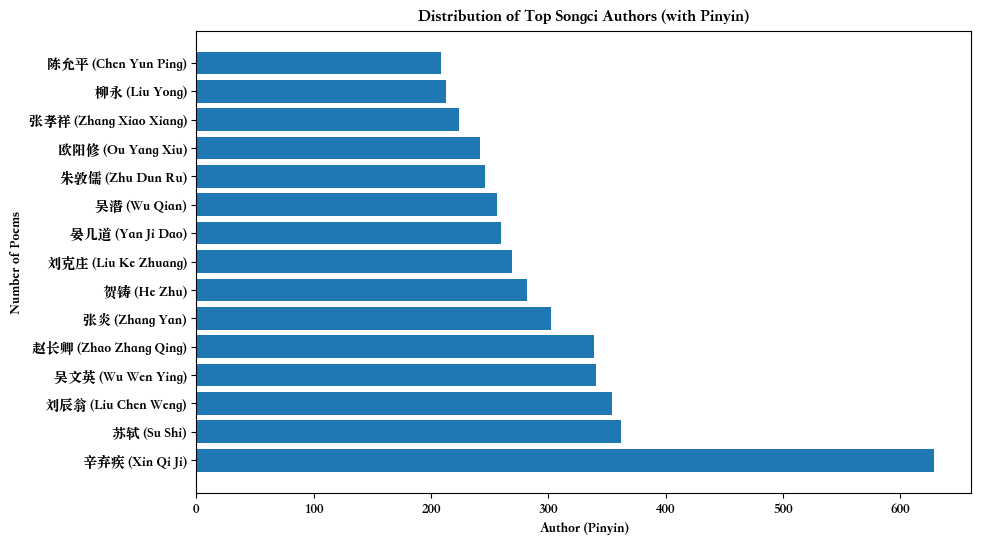

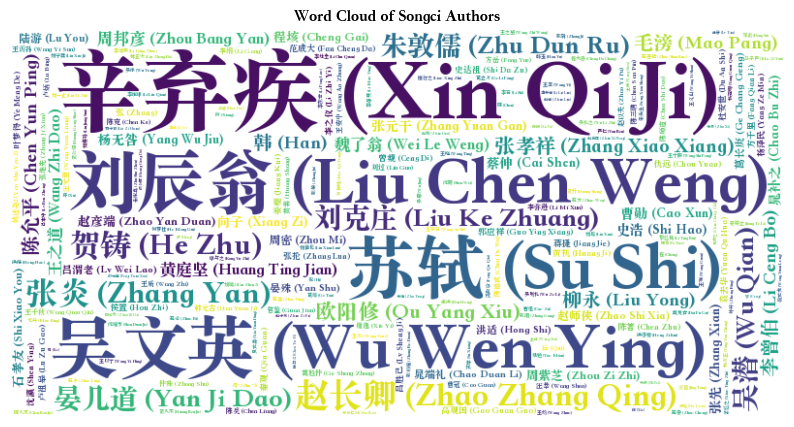

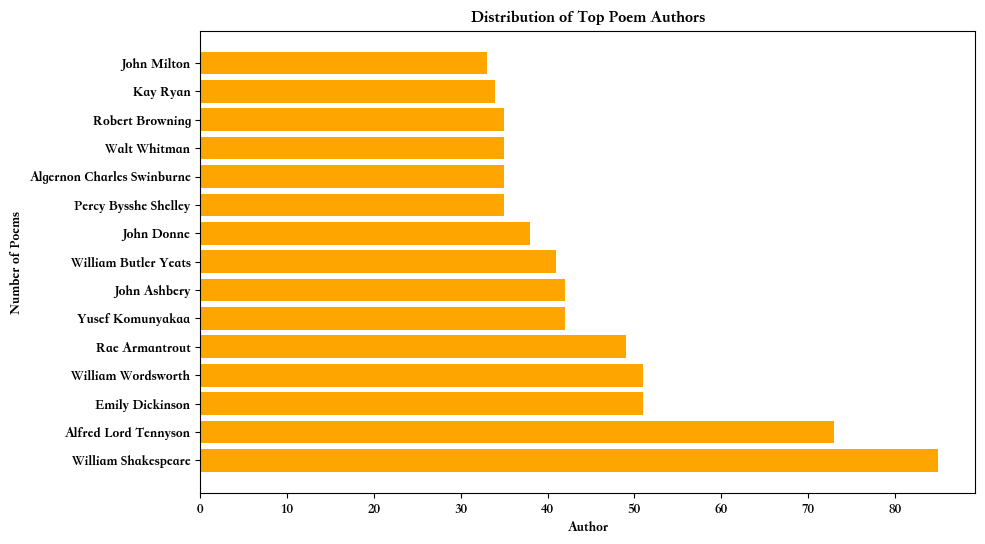

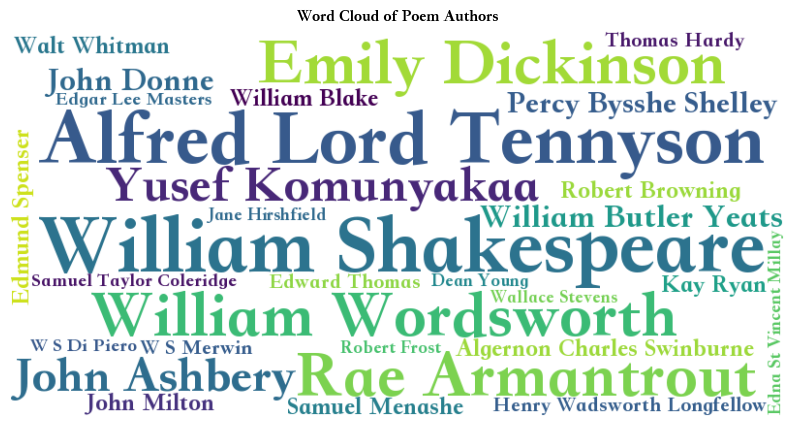

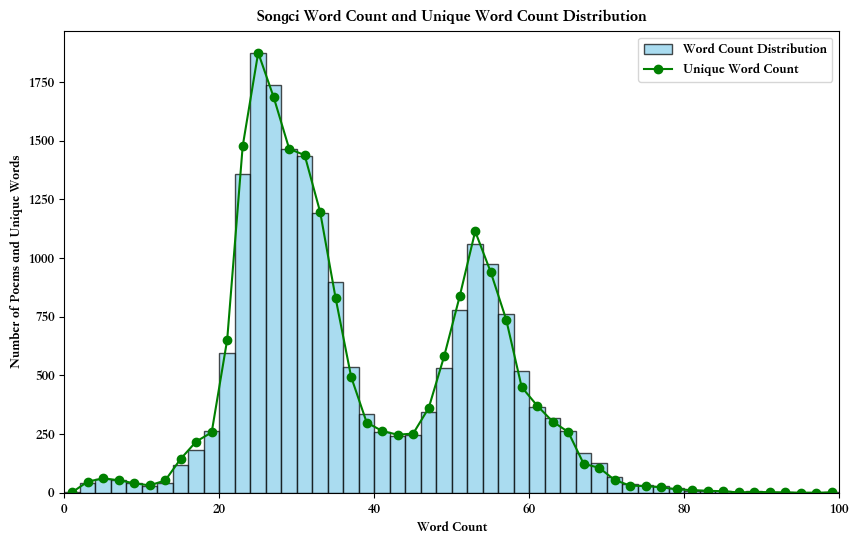

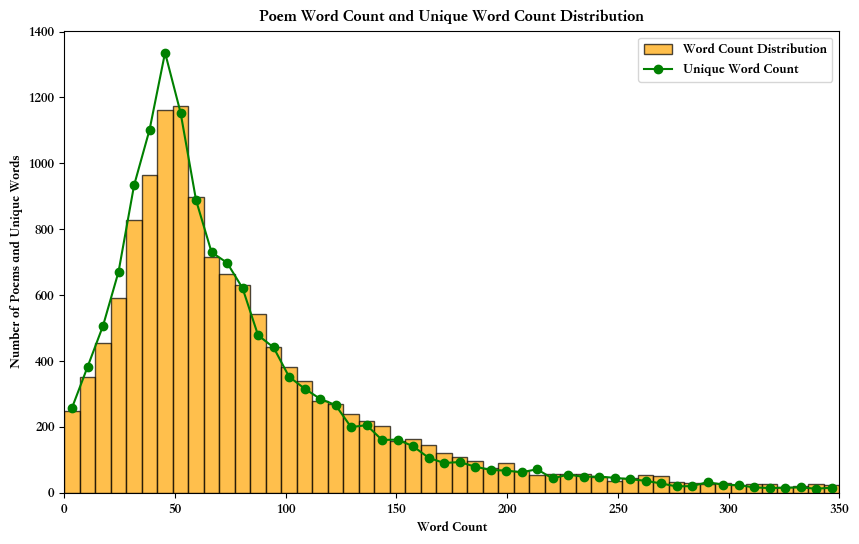

In [ ]:
# ----- EDA ----- #
def generate_wordcloud(freq_dict, title):
    wordcloud = WordCloud(
        font_path='/Library/Fonts/Songti.ttc',  
        width=800, 
        height=400, 
        background_color='white', 
        max_words=200
    ).generate_from_frequencies(freq_dict)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

    return wordcloud

# Author Distribution

## SongCi
### Count the number of poems by each author
author_counts = df_ci['author'].value_counts() # Count the number of poems by each author
top_ci_authors = author_counts[author_counts >= np.percentile(author_counts, 99)] # Get the top prolific authors

### Convert Chinese characters to Pinyin
def convert_to_pinyin(text):
    pinyin_list = pypinyin.lazy_pinyin(text) # Convert Chinese characters to Pinyin
    capitalized_pinyin = [word.capitalize() for word in pinyin_list]  # Capitalize the first letter of each word
    return ' '.join(capitalized_pinyin)


def create_bilingual_label(author):
    pinyin = convert_to_pinyin(author)  # Convert Chinese characters to Pinyin
    return f"{author} ({pinyin})"  # Combine Chinese characters and Pinyin

top_ci_authors_bilingual = top_ci_authors.index.map(create_bilingual_label)

### Plot the distribution of top authors
plt.figure(figsize=(10, 6))
plt.barh(top_ci_authors_bilingual, top_ci_authors.values)
plt.title('Distribution of Top Songci Authors (with Pinyin)')
plt.xlabel('Author (Pinyin)')
plt.ylabel('Number of Poems')
plt.show()

### Create a word cloud of authors

author_bilingual_labels = df_ci['author'].map(create_bilingual_label)
author_freq_dict_bilingual = dict(author_bilingual_labels.value_counts())
wordcloud_ci_authors = generate_wordcloud(author_freq_dict_bilingual, 'Word Cloud of Songci Authors')

## Poem
### Count the number of poems by each author
top_poem_authors = df_poem['poet'].value_counts().head(15) # Get the top prolific authors

### Plot the distribution of top authors
plt.figure(figsize=(10, 6))
plt.barh(top_poem_authors.index, top_poem_authors.values, color='orange')
plt.title('Distribution of Top Poem Authors')
plt.xlabel('Author')
plt.ylabel('Number of Poems')
plt.show()

### Create a word cloud of authors
top_poem_authors_30 = df_poem['poet'].value_counts().nlargest(30)
poet_freq_dict = dict(top_poem_authors_30)

wordcloud_poem_authors = generate_wordcloud(poet_freq_dict, 'Word Cloud of Poem Authors')

# Word Count Distribution

def plot_word_count_distribution(df, token_column, max_range, title, colour, bin_num=50):
    """
    Plot the distribution of word count and unique word count for a dataset
    df: Poem dataset
    token_column: Column containing tokenized content
    max_range: Maximum range for the x-axis in the histogram
    title: Title of the plot
    bin_num: Number of bins for the histogram
    """

    df['word_count'] = df[token_column].apply(len)  # Total word count
    df['unique_word_count'] = df[token_column].apply(lambda x: len(set(x)))  # Unique word count

    fig, ax = plt.subplots(figsize=(10,6)) # Create a figure and axis

    # Histogram: word count distribution
    counts, bins, patches = ax.hist(df['word_count'], bins=bin_num, range=(0, max_range), color=colour, edgecolor='black', alpha=0.7, label='Word Count Distribution')
    ax.set_xlabel('Word Count')
    ax.set_ylabel('Number of Poems and Unique Words')
    ax.tick_params(axis='y')
    ax.set_xlim(0, max_range)

    # Histogram to scatter line
    unique_counts, bin_edges = np.histogram(df['unique_word_count'], bins=bin_num, range=(0, max_range))
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    ax.plot(bin_centers, unique_counts, color='green', marker='o', linestyle='-', label='Unique Word Count')

    # Title and legend
    plt.title(title)
    ax.legend(loc='upper right')

    # Show the plot
    plt.show()

## Word Count Distribution for Songci
plot_word_count_distribution(df_ci, 'tokenized_content', 100, 'Songci Word Count and Unique Word Count Distribution', colour = 'skyblue')

## Word Count Distribution for Poem
plot_word_count_distribution(df_poem, 'cleaned_poem_tokens', 350, 'Poem Word Count and Unique Word Count Distribution', colour = 'orange')


As is shown above, for Chinese poems, Xin Qi Ji (辛弃疾)leads with over 600 poems, followed by Su Shi (苏轼) and others. Songci poets often left behind many shorter works due to the structured nature of ci forms. While for English poems, Shakespeare leads with over 80 poems. English poets generally wrote fewer poems, but each was typically longer. The constraints of the ci form result in a more structured and regular distribution of word counts. In contrast, English poetry is freer in form, with higher average word counts and fewer works per poet.

Top-40 frequent words:     Word  Frequency
219    东风       1274
403    何处       1162
991    人间       1045
1160   风流        769
3582   西风        756
1092   归来        746
147    春风        745
533    梅花        684
308    归去        683
127    江南        656
596    相思        654
2012   如今        620
2188   回首        611
4328   阑干        608
918    多少        597
214    千里        580
216    明月        528
789    万里        520
1992   相逢        500
167    芳草        499
552    黄昏        497
2588   天涯        490
1001   当年        483
128    依旧        458
576    风雨        456
766    斜阳        437
1017   当时        436
3349   风月        414
1153   无人        405
989    多情        405
662    尊前        398
213    故人        392
4987   一笑        388
1535   凄凉        385
961    深处        382
677    不知        379
350    无限        376
2190   不见        375
138    平生        370
170    春色        360
Top-40 frequent words:       Word  Frequency
3595    广寒宫         91
1790    留不住         74
1572    三十六         61
618

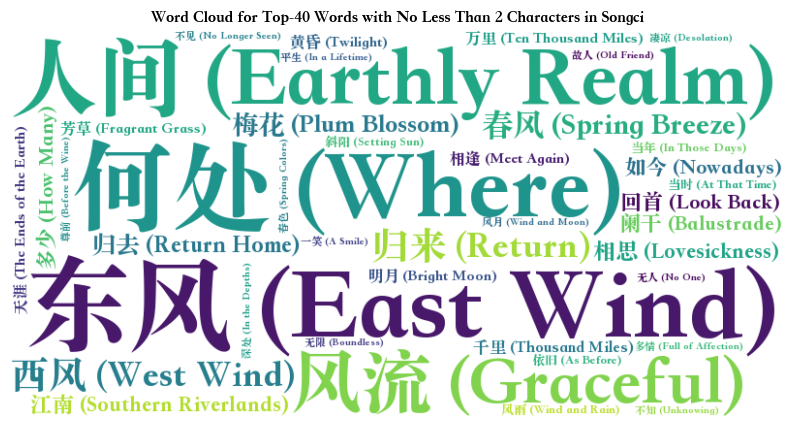

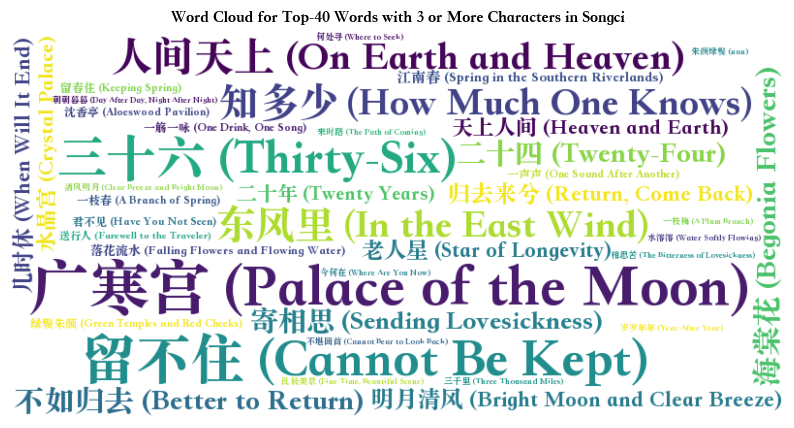

Top-40 frequent words:           Word  Frequency
119        like      14561
107       still       3699
296        love       3598
1653      night       3310
195        back       3073
824      though       2940
781        said       2895
407        time       2832
150        must       2761
427        know       2535
1172    nothing       2495
552        made       2438
1425       life       2318
281       world       2264
1137    without       2252
325        eyes       2240
557       whose       2234
1572       upon       2154
1390       make       2124
711       might       2089
794        long       2023
502      around       1981
484        body       1970
198   something       1894
365        come       1882
533        hand       1847
2471       thou       1826
1163      water       1807
105        away       1787
590       heart       1754
350       light       1752
810        home       1747
499        face       1745
188       death       1741
96        years       1738
367   

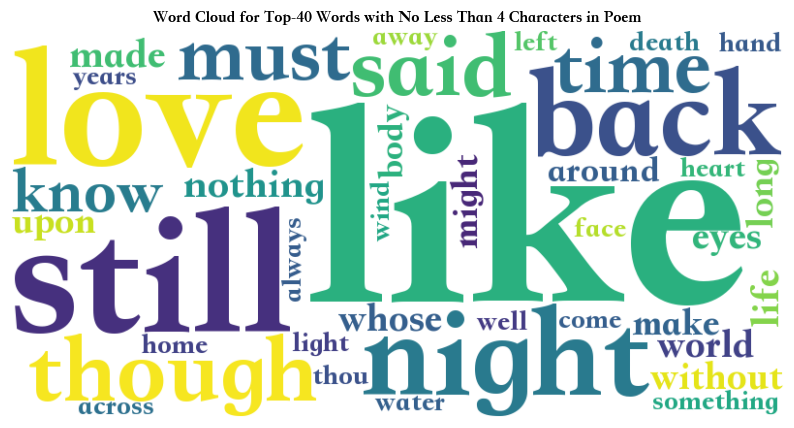

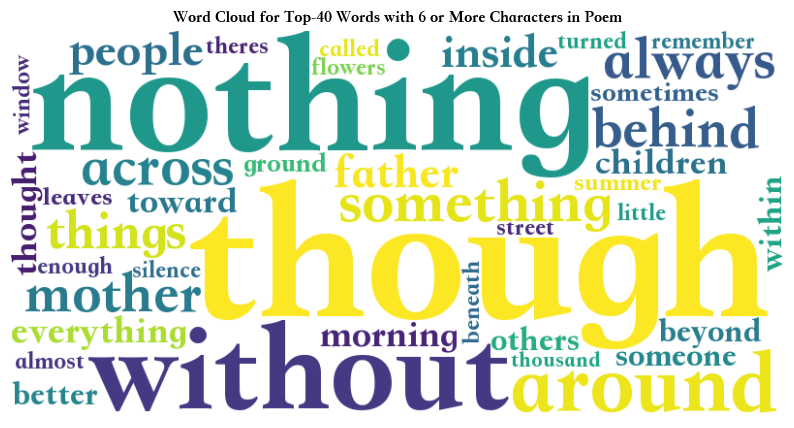

In [ ]:
# Word Frequency Distribution and Word Cloud

def word_freq_analysis(df, tokenized_col, stopwords = None, word_len_filter = 1, top_n = 20):
    '''
    Analyze word frequency in a dataset, return a top-n frequent words
    df: Poem dataset
    tokenized_col: Column containing tokenized content
    stopwords: List of stopwords to remove
    word_len_filter: Minimum length of words to include
    top_n: Number of top words to display
    '''
    if stopwords is None:
        stopwords = set()

    # Get all words with filtering
    all_tokens = df[tokenized_col]  # Get all tokens
    words = [word for content in all_tokens for word in content]  # Flatten the list of tokens
    filtered_words = [word for word in words if word not in stopwords]  # Remove stopwords
    all_filtered_words = [word for word in filtered_words if len(word) >= word_len_filter]  # Remove short words

    # Count word frequency to dataframe
    word_freq = Counter(all_filtered_words)  # Count word frequency
    word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)  # Convert to DataFrame

    # Display top-n frequent words
    top_n_words = word_freq_df.head(top_n)
    print(f'Top-{top_n} frequent words:{top_n_words}')

    return top_n_words

## Songci

ci_word_freq_2char = word_freq_analysis(df_ci, 'tokenized_content', stopwords=STOP_WORDS_CN, word_len_filter=2, top_n=40) # Top 40 frequent words with no less than 2 characters
ci_word_freq_3char = word_freq_analysis(df_ci, 'tokenized_content', stopwords=STOP_WORDS_CN, word_len_filter=3, top_n=40)  # Top 40 frequent words with 3+ characters

### Due to the accuracy of the translation, we will manually obtain and translate the top 20 frequent words for demonstration
translations_ci_word_freq_2char = {
    '东风': 'East Wind',
    '何处': 'Where',
    '人间': 'Earthly Realm',
    '风流': 'Graceful',
    '西风': 'West Wind',
    '归来': 'Return',
    '春风': 'Spring Breeze',
    '梅花': 'Plum Blossom',
    '归去': 'Return Home',
    '江南': 'Southern Riverlands',
    '相思': 'Lovesickness',
    '如今': 'Nowadays',
    '回首': 'Look Back',
    '阑干': 'Balustrade',
    '多少': 'How Many',
    '千里': 'Thousand Miles',
    '明月': 'Bright Moon',
    '万里': 'Ten Thousand Miles',
    '相逢': 'Meet Again',
    '芳草': 'Fragrant Grass',
    '黄昏': 'Twilight',
    '天涯': 'The Ends of the Earth',
    '当年': 'In Those Days',
    '依旧': 'As Before',
    '风雨': 'Wind and Rain',
    '斜阳': 'Setting Sun',
    '当时': 'At That Time',
    '风月': 'Wind and Moon',
    '无人': 'No One',
    '多情': 'Full of Affection',
    '尊前': 'Before the Wine',
    '故人': 'Old Friend',
    '一笑': 'A Smile',
    '凄凉': 'Desolation',
    '深处': 'In the Depths',
    '不知': 'Unknowing',
    '无限': 'Boundless',
    '不见': 'No Longer Seen',
    '平生': 'In a Lifetime',
    '春色': 'Spring Colors'
}

translations_ci_word_freq_3char = {
    '广寒宫': 'Palace of the Moon',
    '留不住': 'Cannot Be Kept',
    '三十六': 'Thirty-Six',
    '人间天上': 'On Earth and Heaven',
    '不如归去': 'Better to Return',
    '东风里': 'In the East Wind',
    '海棠花': 'Begonia Flowers',
    '知多少': 'How Much One Knows',
    '二十四': 'Twenty-Four',
    '寄相思': 'Sending Lovesickness',
    '归去来兮': 'Return, Come Back',
    '明月清风': 'Bright Moon and Clear Breeze',
    '老人星': 'Star of Longevity',
    '几时休': 'When Will It End',
    '天上人间': 'Heaven and Earth',
    '水晶宫': 'Crystal Palace',
    '二十年': 'Twenty Years',
    '落花流水': 'Falling Flowers and Flowing Water',
    '江南春': 'Spring in the Southern Riverlands',
    '君不见': 'Have You Not Seen',
    '沈香亭': 'Aloeswood Pavilion',
    '一声声': 'One Sound After Another',
    '绿鬓朱颜': 'Green Temples and Red Cheeks',
    '留春住': 'Keeping Spring',
    '一觞一咏': 'One Drink, One Song',
    '一枝春': 'A Branch of Spring',
    '送行人': 'Farewell to the Traveler',
    '今何在': 'Where Are You Now',
    '清风明月': 'Clear Breeze and Bright Moon',
    '一枝梅': 'A Plum Branch',
    '朝朝暮暮': 'Day After Day, Night After Night',
    '来时路': 'The Path of Coming',
    '岁岁年年': 'Year After Year',
    '不堪回首': 'Cannot Bear to Look Back',
    '相思苦': 'The Bitterness of Lovesickness',
    '良辰美景': 'Fine Time, Beautiful Scene',
    '水溶溶': 'Water Softly Flowing',
    '三千里': 'Three Thousand Miles',
    '何处寻': 'Where to Seek',
    '钱塘江': 'Qiantang River'
}


ci_word_freq_2char['Translation'] = ci_word_freq_2char['Word'].map(translations_ci_word_freq_2char)
ci_word_freq_2char['Bilingual'] = ci_word_freq_2char.apply(lambda x: f"{x['Word']} ({x['Translation']})", axis=1)

ci_word_freq_3char['Translation'] = ci_word_freq_3char['Word'].map(translations_ci_word_freq_3char)
ci_word_freq_3char['Bilingual'] = ci_word_freq_3char.apply(lambda x: f"{x['Word']} ({x['Translation']})", axis=1)


print(ci_word_freq_2char)
print(ci_word_freq_3char)

### Create a word cloud of Songci
word_freq_dict_2char = dict(ci_word_freq_2char.set_index('Bilingual')['Frequency'])
wordcloud_ci = generate_wordcloud(word_freq_dict_2char, 'Word Cloud for Top-40 Words with No Less Than 2 Characters in Songci')

word_freq_dict_3char = dict(ci_word_freq_3char.set_index('Bilingual')['Frequency'])
generate_wordcloud(word_freq_dict_3char, title='Word Cloud for Top-40 Words with 3 or More Characters in Songci')




## Poem
stop_word_wordcloud = set(['could','would','should','shall', 'every','even','never','first','the','that'])

poem_word_freq_4char = word_freq_analysis(df_poem, 'cleaned_poem_tokens', stopwords=stop_word_wordcloud, word_len_filter=4, top_n=40) # Top 40 frequent words with no less than 4 characters
poem_word_freq_6char = word_freq_analysis(df_poem, 'cleaned_poem_tokens', stopwords=stop_word_wordcloud, word_len_filter=6, top_n=40) # Top 40 frequent words with 6+ characters

print(poem_word_freq_4char)
print(poem_word_freq_6char)

### Create a word cloud of Poem with 4 characters
word_freq_dict_4char = dict(poem_word_freq_4char.set_index('Word')['Frequency'])
wordcloud_poem = generate_wordcloud(word_freq_dict_4char, 'Word Cloud for Top-40 Words with No Less Than 4 Characters in Poem')


### Create a word cloud of Poem with 6 characters
word_freq_dict_6char = dict(poem_word_freq_6char.set_index('Word')['Frequency'])
generate_wordcloud(word_freq_dict_6char, title='Word Cloud for Top-40 Words with 6 or More Characters in Poem')


The frequency of words in the poems reflect the cultural background of the poets and thematic preferences within each tradition.

***Frequency Variance under Cultural and Thematic Differences***

For **Chinese poetry Songci**, the most frequently used words are likely to be related to nature imagery (e.g., East Wind(东风), Plum Blossom(梅花), Fragrant Grass(芳草), etc.), transience and nostalgia (e.g., Return(归去), Look Back(回首), Longing(相思), etc.), and Philosophical reflections (e.g., Earth(人间), Heaven(天地), Where(何处), etc.).

The most frequent word in the Chinese poems Songci is  **"East Wind"(东风)**, with 1274 occurrences. Nature imagery like this is more focused and detailed, reflecting how traditional Chinese poetry often uses nature as a metaphor for complex human emotions and experiences.

For **English poetry**, the most frequently used words are likely to be related to emotions and relationships (e.g., Love, Heart, Life, etc.), philosophical reflections (e.g., Time, Night, Light, etc.), and actions or movements (e.g., Come, Breath, Away, etc.).

The most frequent word in the English poems is **"Like"**, with 14561 occurrences, followed by **"Love"** (3598 occurrences). This overwheming emphasis on simile and metaphor (as indicated by the word "like") and strong emotional expression (as indicated by the word "love") is characteristic of English poetry.

***Structural and  Linguistic Observations***

Chinese poetry is often more compact due to the nature of the Chinese language. For example, words like “东风”(East Wind) are only two characters long, while the English equivalent requires more syllables and characters. This compactness can give Chinese poems a more rhythmic and musical flow, whereas English poetry may focus more on the rhytm through syllabic count and sound patterns.

Another observation is that, many of the top frequent words in English are action-oriented, such as "come", "know", "love", etc., which suggests that english poetry may focus more on narrative movement and changes in state, while Chinese poetry may focus more on static imagery and stillness observation with reflection, as seen in terms like “梅花”(Plum Blossom) and “黄昏”(Twilight).

To specifically point out, when breaking down the words of English poems into tokens, it was not brutally done by splitting the words by space, but by finding the chunks of words that are meaningful and can be treated as a single token, as we want to preserve the meaning of the words as much as possible, especially when comparing the two languages. However, the result still shows that the most frequent words are those single words themselves, rather than the chunks most of the time. It also reflects the nature of English poetry that is more focused on individual words and their meanings, rather than the whole phrases or sentences.

---

## Latent Dirichlet Allocation (LDA) Topic Modeling with Dimensionality Reduction

### Technique Introduction

***LDA***

Latent Dirichlet Allocation (LDA) is a very useful technique for topic modeling in text data. It aims to uncover the hidden thematic structure in a collection of documents. 

LDA assumes that each documen (i.e. each poem) is a mixture of several topics with some distribution, and each topic is a distribution of words. The goal of LDA is to infer the topic distribution of each document and the word distribution of each topic.

***Dimensionality Reduction: t-SNE***

Dimensionality reduction is a technique used to reduce the number of features (i.e. dimensions) in a dataset. In the context of natural language processing, texts are often represented as high-dimensional vectors. Particularly, LDA will return a high-dimensional vector for each document, where each dimension corresponds to a topic, and also each topic is represented as a high-dimensional vector of words. To visualize the results of LDA and have a better understanding of the topics, especially their relationships, we can use dimensionality reduction techniques to reduce the dimensionality of the data to 2 or 3 dimensions.

Here in python library `pyLDAvis`, the dimensionality reduction is realized by using the **t-SNE** algorithm, which is a similar but more advanced technique than PCA. It better captures the non-linear structure of the data and maintains the local similarities between data points. To be specific, it first try to calculate the similarity between data points in the high-dimensional space via a **Gaussian kernel**, and then it tries to find a low-dimensional representation of the data with t distribution that preserves these similarities as much as possible. The optimization goal is to minimize the Kullback-Leibler divergence between the high-dimensional and low-dimensional data, to make sure the similarity structure is well preserved.

> *Reference*
> - Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent Dirichlet Allocation. Journal of Machine Learning Research, 3, 993–1022.
> - van der Maaten, L., & Hinton, G. (2008). Visualizing data using t-SNE. Journal of Machine Learning Research, 9(Nov), 2579–2605.


### LDA Implementation

#### Song Ci LDA Topic Modeling

In [ ]:
# LDA Training
## Songci 

dictionary_ci = corpora.Dictionary(df_ci['tokenized_content'])  # Create a dictionary
corpus_ci = [dictionary_ci.doc2bow(text) for text in df_ci['tokenized_content']]  # Create a corpus
lda_ci = LdaModel(corpus=corpus_ci, id2word=dictionary_ci, num_topics=5, passes=30, random_state=52)  # Train an LDA model

for i, topic in lda_ci.print_topics():
    print(f'Topic {i+1}: {topic}')

Topic 1: 0.002*"岁" + 0.002*"年" + 0.002*"有" + 0.002*"长生" + 0.002*"和" + 0.001*"与" + 0.001*"人间" + 0.001*"在" + 0.001*"蟠桃" + 0.001*"神仙"
Topic 2: 0.002*"娟" + 0.002*"怅" + 0.001*"闹" + 0.001*"屡" + 0.001*"饱" + 0.001*"佩环" + 0.001*"风寒" + 0.001*"丝丝" + 0.001*"征衫" + 0.001*"真是"
Topic 3: 0.002*"万顷" + 0.001*"收拾" + 0.001*"簪" + 0.001*"山河" + 0.001*"蕖" + 0.001*"瀛洲" + 0.001*"直" + 0.001*"文" + 0.001*"玉皇" + 0.001*"缺词"
Topic 4: 0.007*"谁" + 0.007*"是" + 0.006*"又" + 0.006*"月" + 0.005*"与" + 0.005*"更" + 0.004*"有" + 0.004*"在" + 0.004*"去" + 0.004*"还"
Topic 5: 0.001*"杖" + 0.001*"句" + 0.001*"君王" + 0.001*"矣" + 0.001*"事业" + 0.001*"扑" + 0.001*"之" + 0.001*"殿" + 0.001*"长啸" + 0.001*"谈笑"


Here, we set the number of topics of each poem to be 5, total rounds of iteration to be 30. The results are translated as follows:
- **Topic 1 *(Time and immortality)*** : 岁 (Age), 年 (Year), 有 (Have), 长生 (Eternal Life), 和 (And), 与 (With), 人间 (Human World), 在 (Exist), 蟠桃 (Peach of Immortality), 神仙 (Immortal)

- **Topic 2 *(Melancholy and personal reflection)***: 娟 (Delicate), 怅 (Melancholy), 闹 (Noisy), 屡 (Repeatedly), 饱 (Full), 佩环 (Jade Ornaments), 风寒 (Cold Wind), 丝丝 (Thread-like), 征衫 (Traveler's Robe), 真是 (Truly)

- **Topic 3 *(Vast landscapes, legendary the celestial world.)***: 万顷 (Vast Expanse), 收拾 (Gather), 簪 (Hairpin), 山河 (Mountains and Rivers), 蕖 (Lotus), 瀛洲 (Fairyland), 直 (Straight), 文 (Culture), 玉皇 (Jade Emperor)

- **Topic 4 *(Philosophical and introspective)***: 谁 (Who), 是 (Is), 又 (Again), 月 (Moon), 与 (With), 更 (Even More), 有 (Has), 在 (Is), 去 (Leave), 还 (Return)

- **Topic 5 *(Royalty, authority, power and ambition)***: 杖 (Staff), 句 (Phrase), 君王 (King), 矣 (Final Particle), 事业 (Enterprise), 扑 (Pounce), 之 (Of), 殿 (Palace), 长啸 (Long Whistle), 谈笑 (Chat and Laugh)


---

This topic modeling result can also be visualized in a 2D space using t-SNE, as shown below: (Note that you may interact with the plot to see the details of each topic as well. Though the order of the topics may be different from the above list, the content of each topic is basically the same.)

In [ ]:
lda_ci_topics_vis = gensimvis.prepare(lda_ci, corpus_ci, dictionary_ci)
pyLDAvis.display(lda_ci_topics_vis)

And here is a brief introduction to the plot shown above.

First, the left side of the plot, aka the **Inter-topic Distance Map**, shows the relationship between different topics. The closer the circles are, the more similar the topics are related regarding the words distribution. The size of the circles represents the weight of the topics in the whole corpus, i.e. the contribution of the topics to the whole poem collection. 

By clicking the circles or indicating the `selected topic`, the right side of the plot, aka the **Top-30 Most Relevant Terms** for the selected topic, will be highlighted in red. The value of the highlighted red bar is the frequency of the term in the selected topic, and the blue bar is the frequency of the term in the whole corpus(whole poems collection). 

There is also a slider on the top of the plot, which can be used to adjust the relevance $\lambda$ of the terms in the selected topic. When $\lambda$ is close to 1, the terms are ranked simply by their frequency in the selected topic, while when $\lambda$ is close to 0, the terms with higher uniqueness in the selected topic are ranked higher.

---

The following is a demonstration of the LDA topic with respect to a single poem. The code is set to randomly select a poem from the dataset and display the topic distribution of the poem. You may run the cell multiple times to see different results.

In [ ]:
import random

def display_poem_and_lda(lda, corpus, poem_data, text_column, author_column, title_column, idx=None):
    """Display a specific or random poem and its LDA topic distribution and keywords.
    
    Parameters:
    lda -- trained LDA model
    corpus -- corpus with bag-of-words representation of poems
    poem_data -- DataFrame containing the poem data
    text_column -- column name in poem_data that contains the poem text
    author_column -- column name in poem_data that contains the author information
    title_column -- column name in poem_data that contains the poem title
    idx -- (Optional) specific index of the poem to display; if None, a random poem is selected
    """
    # If idx is not provided, randomly select a document (poem)
    if idx is None:
        doc_id = random.randint(0, len(corpus) - 1)
    else:
        doc_id = idx

    # Get the LDA topic distribution for the selected document
    doc_lda = lda[corpus[doc_id]]  # Get topic distribution
    poem_text = poem_data[text_column][doc_id].replace('\r', '') # Get poem text using specified text column
    poem_author = poem_data[author_column][doc_id].replace('\r', '').replace('\n', '')  # Get poem author and remove newline characters
    poem_title = poem_data[title_column][doc_id].replace('\r', '').replace('\n', '')  # Get poem title and remove newline characters    
    # Display the poem text
    print(f"\n=== Poem {doc_id+1} ===")
    print(f"Title: {poem_title}, Author: {poem_author}")
    print('----------')
    print(f"{poem_text}")
    
    # Display the LDA topic distribution
    print("\n=== Topic Distribution ===")
    for topic_id, prob in doc_lda:
        # Get the top 8 keywords for each topic
        topic_keywords = lda.show_topic(topic_id, topn=8)
        keywords = ", ".join([f"{word} ({weight:.2f})" for word, weight in topic_keywords])
        print(f"Topic {topic_id}: {prob:.2%}, Keywords: {keywords}")

# Example usage for Chinese Songci:
display_poem_and_lda(lda_ci, corpus_ci, df_ci, text_column='content', author_column='author', title_column='rhythmic')


=== Poem 752 ===
Title: 夜行船, Author: 欧阳修
----------
满眼东风飞絮。
催行色、短亭春暮。
落花流水草连云，看看是、断肠南浦。
檀板未终人去去。
扁舟在、绿杨深处。
手把金尊难为别，更那听、乱莺疏雨。

=== Topic Distribution ===
Topic 3: 95.29%, Keywords: 谁 (0.01), 是 (0.01), 又 (0.01), 月 (0.01), 与 (0.00), 更 (0.00), 有 (0.00), 在 (0.00)
Topic 4: 3.01%, Keywords: 杖 (0.00), 句 (0.00), 君王 (0.00), 矣 (0.00), 事业 (0.00), 扑 (0.00), 之 (0.00), 殿 (0.00)


#### English Poems LDA Topic Modeling

Now, we will apply the same LDA topic modeling technique to the English poems dataset. The results are translated as follows:

In [ ]:
# Additional Cleaning
additional_stopwords = {'one', 'us', 'could', 'like', 'two', 'said', 'upon', 'would', 'may', 'must', 'yet', 'shall', 'much', 'also', 'every', 'even', 'never', 'first', 'im', 'dont'} # According to the output of the naive LDA model, here we add some common words to the stop words list to improve the model performance
STOP_WORDS_EN = set(stopwords.words('english')).union(additional_stopwords)

def clean_tokens(tokenized_content, min_word_length=3, min_freq=3):
    """
    Further clean the token by filtering out scarce words, single characters and additional stop words

    Parameters:
    - tokenized_content: the tokenized document
    - min_word_length: minimum word length, default is 2
    - min_freq: minimum word frequency, words with a frequency lower than this will be filtered out
    """
    # Filter out single characters, punctuation, and stop words
    cleaned_content = [
        word for word in tokenized_content 
        if len(word) >= min_word_length and word not in string.punctuation and word.lower() not in STOP_WORDS_EN
    ]
    
    # Create word frequency dictionary
    word_freq = {}
    for word in cleaned_content:
        word_freq[word] = word_freq.get(word, 0) + 1
    
    # Filter out words that do not meet the minimum frequency threshold
    cleaned_content = [word for word in cleaned_content if word_freq[word] >= min_freq]
    
    return cleaned_content

# Apply the cleaning function to the Poem dataset
df_poem['cleaned_poem_tokens_filtered'] = df_poem['cleaned_poem_tokens'].apply(clean_tokens)

# Train the LDA model with the filtered tokens
dictionary_poem = corpora.Dictionary(df_poem['cleaned_poem_tokens_filtered'])
corpus_poem = [dictionary_poem.doc2bow(text) for text in df_poem['cleaned_poem_tokens_filtered']]

lda_poem = LdaModel(corpus=corpus_poem, id2word=dictionary_poem, num_topics=5, passes=25, random_state=42)

for idx, topic in lda_poem.print_topics(num_words=10):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.031*"time" + 0.028*"say" + 0.026*"way" + 0.024*"know" + 0.018*"though" + 0.017*"something" + 0.016*"life" + 0.016*"without" + 0.014*"come" + 0.013*"back"
Topic 1: 0.067*"love" + 0.042*"man" + 0.038*"still" + 0.020*"mother" + 0.019*"whose" + 0.017*"face" + 0.016*"men" + 0.015*"want" + 0.014*"tell" + 0.013*"eyes"
Topic 2: 0.039*"thou" + 0.026*"thee" + 0.019*"god" + 0.019*"night" + 0.014*"day" + 0.014*"thy" + 0.013*"though" + 0.013*"death" + 0.012*"let" + 0.011*"heart"
Topic 3: 0.024*"nothing" + 0.017*"back" + 0.015*"house" + 0.013*"city" + 0.009*"years" + 0.009*"lord" + 0.009*"behind" + 0.008*"john" + 0.008*"room" + 0.008*"sand"
Topic 4: 0.028*"body" + 0.022*"water" + 0.020*"father" + 0.018*"see" + 0.013*"three" + 0.011*"people" + 0.011*"blood" + 0.010*"says" + 0.009*"boy" + 0.009*"look"


Here, we set the number of topics of each poem to be 5, total rounds of iteration to be 30. The results are as follows:

- **Topic 1 *(Time and life experiences)***: time, say, way, know, though, something, life, without, come, back

- **Topic 2 *(Love and human relationships)***: love, man, still, mother, whose, face, men, want, tell, eyes

- **Topic 3 *(Religion and mortality)***: thou, thee, god, night, day, thy, though, death, let, heart

- **Topic 4 *(Places and memories)***: nothing, back, house, city, years, lord, behind, john, room, sand

- **Topic 5 *(Body and family)***: body, water, father, see, three, people, blood, says, boy, look


---

A visualization of the LDA topic modeling results for English poems is shown below.

In [ ]:
lda_poem_topics_vis = gensimvis.prepare(lda_poem, corpus_poem, dictionary_poem)
pyLDAvis.display(lda_poem_topics_vis)


---

Similar to the Chinese poems, you may also run the cell below to see the topic distribution of a randomly selected English poem:

In [ ]:
# Example usage for English Poem:
display_poem_and_lda(lda_poem, corpus_poem, df_poem, text_column='poem_text', author_column='poet', title_column='poem_title')


=== Poem 3596 ===
Title:                     Beulah peel me a grape                , Author: Patricia Spears Jones
----------

First, Beulah has no idea where the damn grape is.
She just got her manicure and frankly could care less.
She does find the cocky Cockney cute.
But, so does that glittery Lil and well---
It’s Lil’s Big Show.
 
Lil has blood on her hands, and rubs in the almond
scented lotion, while she waits for that peeled grape.
 
Beulah pours a large portion of gin
and recalls the Minstrel shows, Bessie Smith,
chicken dinners in a picnic basket,
and a guy named Roy. He was no prince,
but a king of the bedroom rambles.
 
Elsewhere, boots are beating the ground, leaving
bloodied feet and untended harvests
as glass breaks across the faces of Polish Jews
and the Spanish Republicans fight black clad insurgents.
More boots, pretty, shiny, well-made boots.
“until the war” says Tom in  The Glass Menagerie.
When America  sits  in a “dark room” and watches
“until the war”.  Death’s s

## Word2Vec and Doc2Vec with Clustering and Dimensionality Reduction

### Technique Introduction

***Word2Vec & Doc2Vec***

Word2Vec and Doc2Vec are two powerful techniques for word and document embedding, respectively. They are based on neural networks and can transform words and documents from one-hot encoding to dense vectors in a continuous space. Such architectures can capture the semantic and syntactic relationships between words and documents, which is very useful for many NLP tasks. Word2Vec is used to represent words in a continuous space, where words with similar meanings are close to each other. Doc2Vec is an extension of Word2Vec from words to documents, which can represent documents as dense vectors in the same continuous space, and can be used for document similarity, clustering, and classification.

***k-Means Clustering***

Clustering is an unsupervised learning technique that groups similar data observations together. k-Means is a popular clustering algorithm that partitions the data into k clusters. It works by iteratively assigning data points to the nearest cluster center and updating the cluster centers based on the mean of the data points in each cluster. The algorithm converges when the cluster assignments no longer change.

***Dimensionality Reduction: PCA***

Principal Component Analysis (PCA) is a technique used to reduce the dimensionality of a dataset (i.e. the number of features) while preserving the variance in the data. It works by finding the principal components of the data, which is the eigenvectors of the covariance matrix. These principal components are orthogonal to each other and capture the directions of maximum variance in the data. By projecting the data onto the principal components, we can reduce the dimensionality of the data while retaining most of the variance.

> *Reference*: 
> - Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781.
> - Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013). Distributed representations of words and phrases and their compositionality. Advances in Neural Information Processing Systems, 26.
> - Le, Q., & Mikolov, T. (2014). Distributed representations of sentences and documents. In Proceedings of the 31st International Conference on Machine Learning (pp. 1188-1196).
> - Jolliffe, I. T. (2002). Principal component analysis (2nd ed.). Springer.
> - MacQueen, J. (1967). Some methods for classification and analysis of multivariate observations. In Proceedings of the Fifth Berkeley Symposium on Mathematical Statistics and Probability (Vol. 1, pp. 281–297).





### Word2Vec Implementation

#### Song Ci Word2Vec

First, we will train a Word2Vec model on the Chinese poems dataset. 

In [ ]:
# Train a Word2Vec Model on Songci
ci_sentences = df_ci['tokenized_content'].tolist() # Convert the tokenized content to a list of sentences
ci_model = Word2Vec(ci_sentences, vector_size=200, window=10, min_count=1, sg=1) # Train a Word2Vec model
ci_model.save('songci_word2vec.model') # Save the model

---

***Word Similarity in Chinese Poems***

Technically, the Word2Vec can very well capture the semantic and syntactic relationships between words, as is shown in the following example:

In [ ]:
# Example: Find the most similar words to '春天'(Spring)
similar_words =ci_model.wv.most_similar('春天', topn=10)
print("Most similar words to '春天'(Spring)：", similar_words)

# Example: Find the similarity between '春天'(Spring) and '夏天'(Summer)
similarity = ci_model.wv.similarity('春天', '夏天')
print(f"Similarity between '春天'(Spring) and '夏天'(Summer)： {similarity*100:.2f}%")


Most similar words to '春天'(Spring)： [('浓绿', 0.993222713470459), ('春阴', 0.9919570684432983), ('繁杏', 0.9918365478515625), ('红透', 0.9917570948600769), ('迟日', 0.9915665984153748), ('花市', 0.9915499687194824), ('双飞燕', 0.9915446043014526), ('春日', 0.9914225339889526), ('晴昼', 0.9912555813789368), ('舞困', 0.991135835647583)]
Similarity between '春天'(Spring) and '夏天'(Summer)： 92.43%


Here's a translation of the output above, i.e. an example of the words most similar to the word "Spring" in the Chinese poems dataset:

*Words most similar to 'Spring':*

- 浓绿 (Deep Green) – 99.32%
- 春阴 (Spring Shade) – 99.20%
- 繁杏 (Abundant Apricots) – 99.18%
- 红透 (Fully Reddened) – 99.18%
- 迟日 (Late Day) – 99.16%
- 花市 (Flower Market) – 99.15%
- 双飞燕 (Paired Swallows) – 99.15%
- 春日 (Spring Day) – 99.14%
- 晴昼 (Sunny Day) – 99.13%
- 舞困 (Dance Tiredness) – 99.11%

*Similarity between 'Spring' and 'Summer'*: 92.43%

Note that, the *Similarity* here is not equivalent to the synonymity of the words in linguistic terms, but rather the similarity of the context in which the words are used in the poems. This is why the words most similar to "Spring" are all related to the season of Spring, and the similarity between "Spring" and "Summer" is also high, as they are both seasons.

---

***Word Similarity Network Visualization***

Furthermore, we can accordingly build a similarity map, or network, of the words in the Chinese poems dataset, indicating a further connection between the words and their contexts.

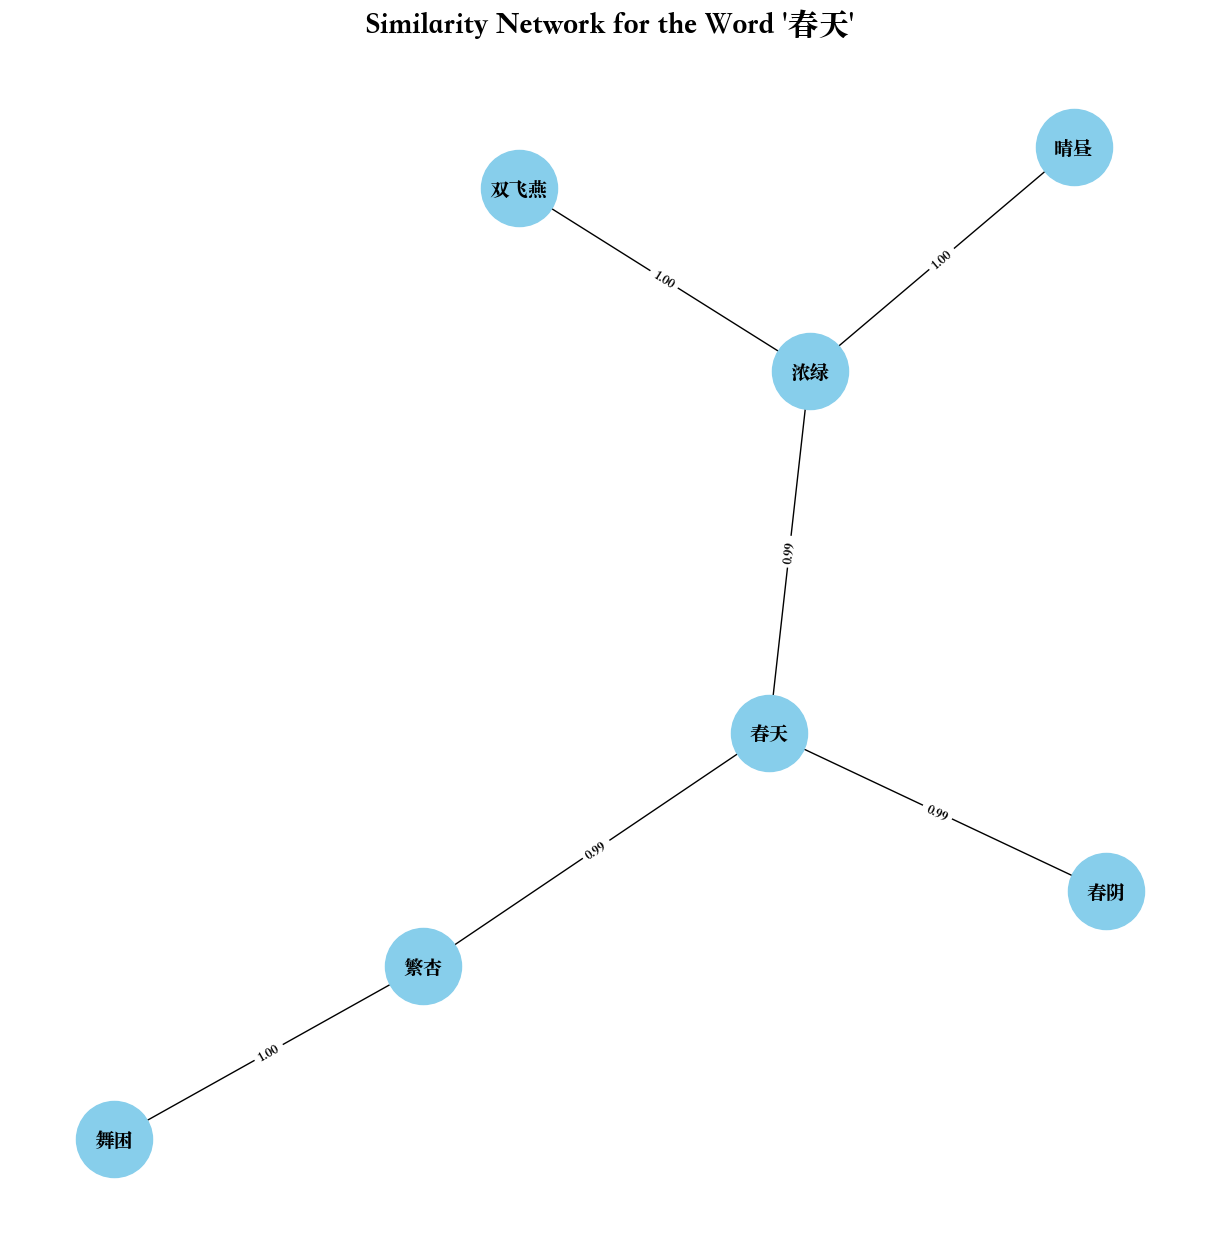

In [ ]:
def plot_network(G, center_word, node_color):
    '''
    Plot a network graph.

    Parameters:
    - G: the network graph
    - center_word: the center word
    - node_color: the color of the nodes
    '''
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G) # Set the layout of the graph
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color=node_color, font_size=14, font_family='Songti SC') # Draw the graph

    edge_labels = nx.get_edge_attributes(G, 'weight') # Get the edge weights
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()}, font_size=10) # Draw the edge weights

    plt.title(f"Similarity Network for the Word '{center_word}'", fontsize=22) # Set the title

    plt.show()

def build_similarity_network (center_word, model, topn=6, max_depth = 3, color = 'skyblue'):
    '''
    Build a network of similar words for a given center word.

    Parameters:
    - center_word: the center word to build the network
    - model: the Word2Vec model
    - topn: the number of similar words to include for each word
    - max_depth: the maximum depth of the network
    '''

    G = nx.Graph() # Create a non-directed graph
    G.add_node(center_word) # Add the center word as the root node

    # Use a queue to perform breadth-first search

    queue = [(center_word, 0)] # Initialize the queue with the center word and depth 0
    visited = set([center_word]) # Initialize a set to store visited words

    while queue:
        current_word, depth = queue.pop(0) # Pop the first element from the queue

        if depth >= max_depth: # If the depth exceeds the maximum depth, skip the current word
            continue

        # Get the most similar words to the current word
        try :
            similar_words = model.wv.most_similar(current_word, topn=topn)
        except KeyError:
            continue

        for similar_word, similarity in similar_words:
            if similar_word not in visited:
                G.add_node(similar_word) # Add the similar word as a node
                G.add_edge(current_word, similar_word, weight=similarity) # Add an edge between the current word and the similar word, with the similarity as the weight
                visited.add(similar_word) # Add the similar word to the visited set
                queue.append((similar_word, depth+1))

    plot_network(G, center_word, color) # Plot the network

    return G



# Build a network for the word '春天' (Spring) in Songci

ci_similarity_network_spring = build_similarity_network('春天', ci_model, topn=3, max_depth=2, color = 'skyblue')


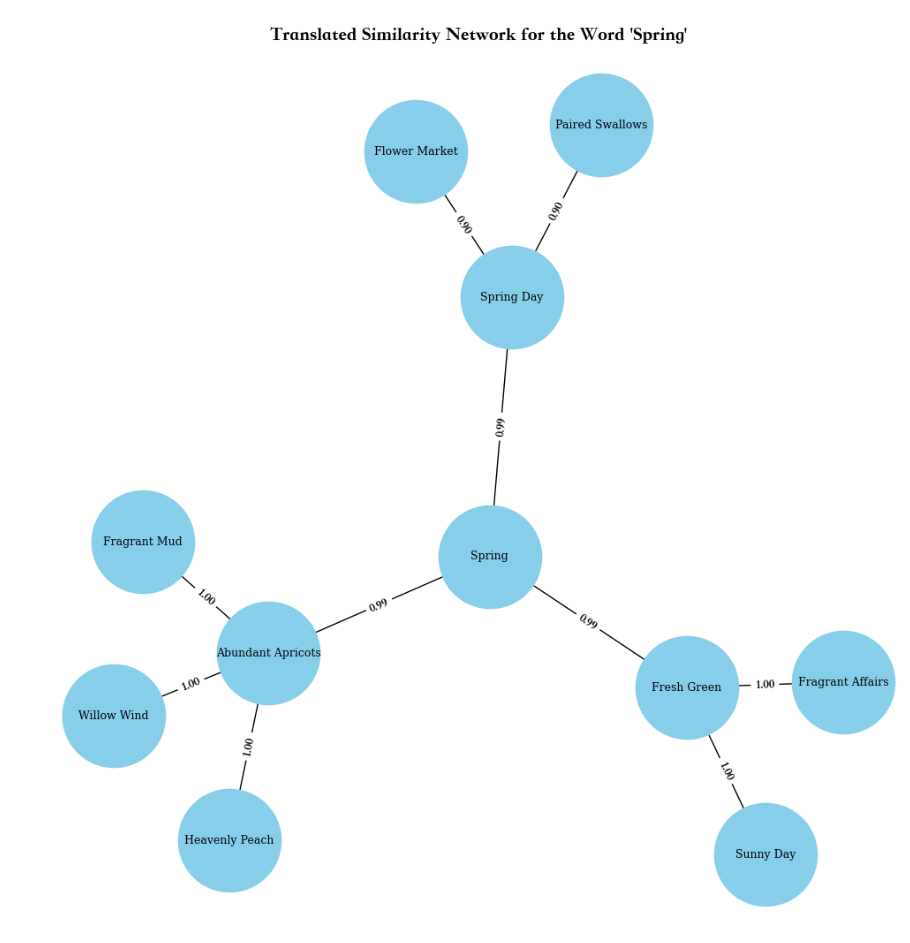

Actually the network can be built to be more complex and detailed, but here we only show a simple version of the network, with a maximum depth of 2 and a maximum degree (number of neighbors) of 3. And the there is also a manually translated version of the network as is shown above.

---

#### English Poems Word2Vec

Similarly, we will train a Word2Vec model on the English poems dataset.

In [ ]:
poem_sentences = df_poem['cleaned_poem_tokens_filtered'].tolist() # Convert the tokenized content to a list of sentences
poem_model = Word2Vec(poem_sentences, vector_size=200, window=10, min_count=4, sg=1) # Train a Word2Vec model
poem_model.save('poem_word2vec.model') # Save the model

It is suprising but also reasonable to see that some of the words most similar to "Spring" in the English poems dataset are also those in the Chinese poems dataset, such as "swallo sister" ("双飞燕" in Chinese poem), which is a very specific and poetic metaphor for the season of Spring. Though having a great difference in the language and culture, human beings share a lot of common feelings and experiences. And this is also reflected in the words used in the poems.

---

This time, we try to build a larger network of the words in the English poems dataset, with a maximum depth of 3 and a maximum degree of 5. The network is shown below:

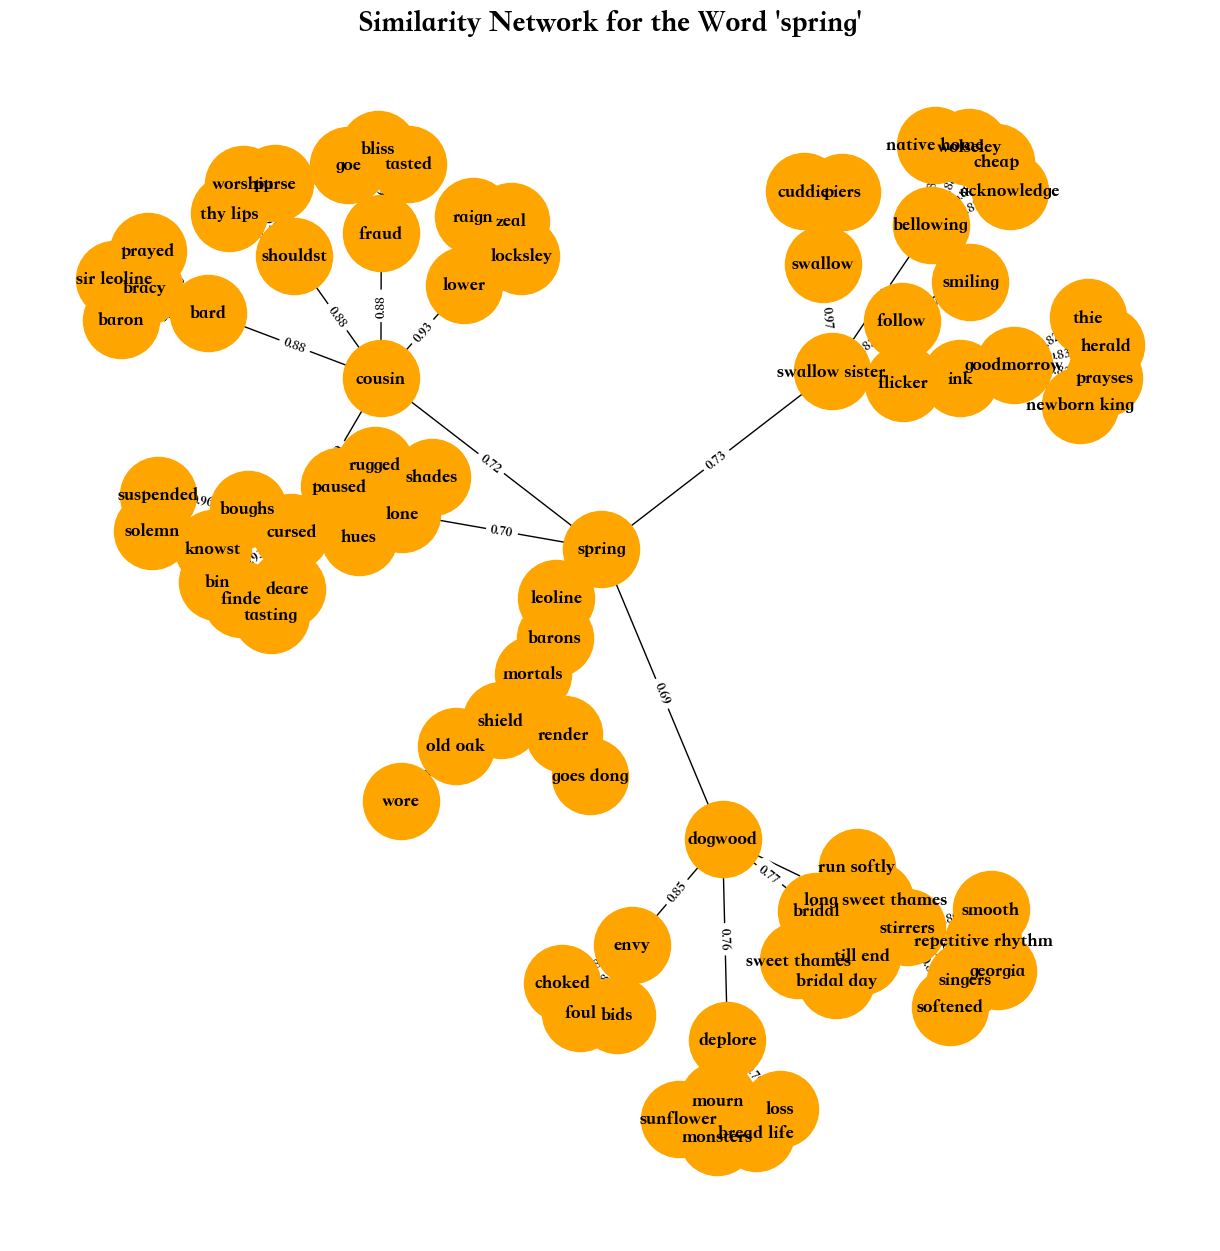

In [ ]:
poem_similarity_network_spring = build_similarity_network('spring', poem_model, topn=5, max_depth=3, color = 'orange')

### K-Means Clustering on Word Vectors

We have trained Word2Vec models on both the Chinese and English poems datasets, and now we will apply k-Means clustering to the word vectors to group similar words together. 

In [ ]:
def wordvect_clustering(model, n_clusters=5):
    '''
    Perform KMeans clustering on the word vectors in a Word2Vec model.

    Parameters:
    - model: the Word2Vec model
    - n_clusters: the number of clusters
    '''
    word_vectors = model.wv # Get the word vectors
    words_list = list(word_vectors.index_to_key) # Get the list of words

    X = np.array([word_vectors[word] for word in words_list]) # Convert the word vectors to an array

    kmeans = KMeans(n_clusters=n_clusters, random_state=336) # Initialize the KMeans model
    kmeans.fit(X) # Fit the model

    labels = kmeans.labels_ # Get the cluster labels

    word_cluster_df = pd.DataFrame({'word': words_list, 'cluster': labels}) # Create a DataFrame with the words and their clusters

    return word_cluster_df

ci_word_cluster_df = wordvect_clustering(ci_model, n_clusters=10)
poem_word_cluster_df = wordvect_clustering(poem_model, n_clusters=10)

A demonstration of the k-Means clustering results for the Chinese poems dataset with 5 clusters and 10 words per cluster is shown below:

In [ ]:
for i in range(5):
    print(f"Cluster {i}: {ci_word_cluster_df[ci_word_cluster_df['cluster'] == i].head(10)}")

Cluster 0:       word  cluster
20530   太岁        0
20639   菊暗        0
20921  八九十        0
21308   吉语        0
21343  晚云收        0
21415   山抹        0
21555   重盟        0
21810   冻痕        0
21915   差别        0
23098   金鞭        0
Cluster 1:    word  cluster
1     是        1
4     与        1
5     更        1
6     有        1
7     在        1
10    我        1
12    不        1
14    为        1
15    年        1
16    都        1
Cluster 2:       word  cluster
8242    爱日        2
8748    方面        2
8851    雨洗        2
10046   凉露        2
10301   拍堤        2
10335   霜林        2
10353   水痕        2
10463   烟林        2
10743   香檀        2
10764    轩        2
Cluster 3:        word  cluster
32318    脸薄        3
32320   难藏泪        3
37968   珠自右        3
39936    由顾        3
40846    乍卷        3
40849   新燕入        3
43191    一忆        3
43192    黑波        3
43193  千岩竞秀        3
43195   结晓鬟        3
Cluster 4:    word  cluster
2     月        4
24   东风        4
41    春        4
44    倚        4
52

Honestly speaking, it is not always easy to interpret the results of k-Means clustering on word vectors, as the processing logic which is based on the vector space is quite different from the human logic. However, we can still try to find some patterns or structures in the clustering results.

For a rough demonstration, here we focus on Cluster 1 and Cluster 4 of the Chinese poems dataset. The words in these clusters are translated as follows:

- **Cluster 1**: 是 (is), 与 (and), 更 (even more), 有 (have), 在 (at/in), 我 (I), 不 (not), 为 (for), 年 (year), 都 (all).
- **Cluster 4**: 月 (moon), 东风 (east wind), 春 (spring), 倚 (lean), 听 (listen), 西风 (west wind), 雨 (rain), 花 (flower), 绣 (embroider), 吹 (blow).

The words in Cluster 1 are more general and common 1-character words . The words in Cluster 4 are mostly nature-related words, which are more specific and poetic. 

Similarly, k-Means clustering results for the English poems dataset are shown below:

In [ ]:
for i in range(5):
    print(f"Cluster {i}: {poem_word_cluster_df[poem_word_cluster_df['cluster'] == i].head(10)}")

Cluster 0:            word  cluster
502      silver        0
602      please        0
815     windows        0
886        skin        0
887        noon        0
999       older        0
1003   gazelles        0
1011  daughters        0
1015     coyote        0
1020      guess        0
Cluster 1:          word  cluster
175      john        1
245      talk        1
255     train        1
266      town        1
298   writing        1
358      died        1
401  beatrice        1
443    number        1
458    church        1
461     wants        1
Cluster 2:      word  cluster
3   still        2
4   night        2
10    day        2
26    sea        2
29   eyes        2
31  heart        2
33   come        2
37   long        2
41   hand        2
42   wind        2
Cluster 3:       word  cluster
0     thou        3
5   though        3
6     thee        3
7    whose        3
9      god        3
21   might        3
24     thy        3
30    thus        3
47   earth        3
49    thir        3

Here, we take Cluster 2 and Cluster 3 as examples:
- **Cluster 2**: still, night, day, sea, eyes, heart, come, long, hand, wind.
- **Cluster 3**: thou, though, thee, whose, god, might, thy, thus, earth, thir.

The patterns are somehow obvious, with Cluster 2 being more related to the nature or physical world; cluster 3 on the other hand seems to be an older cluster of English words, with more archaic and religious terms. And it's also interesting to see that phonetical similarity might also be a factor in the clustering results, as many of the words in Cluster 3 have similar phonetics (e.g. "thou", "thee", "thy", "thus", "thir", etc.).

---

### Doc2Vec Implementation

Lastly, we will train a Doc2Vec model on Chinese poems datasets.

#### Song Ci Doc2Vec

First we will train a Doc2Vec model on the Chinese and English poems dataset.

In [ ]:
ci_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df_ci['tokenized_content'])] # Tag the Songci documents
ci_doc_model = Doc2Vec(ci_documents, vector_size=100, window=10, min_count=2, workers=4, epochs=30) # Train a Doc2Vec model
ci_doc_model.save('songci_doc2vec.model') # Save the model

Now we can use the trained Doc2Vec model to find the poems of similar content or styles.

In [ ]:
def get_similar_documents(doc_id, model, df, token_col, content_col, topn=5):
    '''
    Get the most similar documents to a given document ID.

    Parameters:
    - doc_id: the document ID
    - model: the Doc2Vec model
    - df: the DataFrame containing the documents
    - token_col: the column name of the tokenized content
    - content_col: the column name of the raw content
    - topn: the number of similar documents to return
    '''
    doc_vector = model.infer_vector(df[token_col].iloc[doc_id]) # Infer the vector for the document
    similar_docs = model.dv.most_similar([doc_vector], topn=topn) # Get the most similar documents
    similar_docs = [(similar_doc_id, similarity) for similar_doc_id, similarity in similar_docs if similar_doc_id != doc_id] # remove the target document from the list of similar documents

    print(f"[Target Document ({doc_id})] \n{df[content_col].iloc[doc_id]}") # Print the target document
    print("\n=== Most Similar Documents ===")

   
   
    for similar_doc_id, similarity in similar_docs:
        print(f"[Document {similar_doc_id} (Similarity: {similarity:.2f})]\n{df[content_col].iloc[similar_doc_id]}")
        print("-"*20)

    return similar_docs

get_similar_documents(1459, ci_doc_model, df_ci, 'tokenized_content', 'content', topn=3)
    

[Target Document (1459)] 
明月几时有，把酒问青天。
不知天上宫阙，今夕是何年。
我欲乘风归去，又恐琼楼玉宇，高处不胜寒。
起舞弄清影，何似在人间。
转朱阁，低绮户，照无眠。
不应有恨，何事长向别时圆。
人有悲欢离合，月有阴晴圆缺，此事古难全。
但愿人长久，千里共婵娟。

=== Most Similar Documents ===
[Document 17921 (Similarity: 0.63)]
寒泉溅雪，有环佩隐隐，飞度霜月。
易水风寒，壮士悲歌，关山万里离别。
杨花浩荡晴空转，又化作、云鸿霜鹘。
耿石壕，夜久无言寂历，如闻幽咽。
云谷山人老矣，江空又岁晚，相对愁绝。
玉立长身，自是胎仙，舞我黄庭三叠。
人间只惯丁当字，妙处在、一声清拙。
待明朝、试拂菱花，老我一簪华发。
--------------------
[Document 7041 (Similarity: 0.61)]
昨夜中秋今夕望，十分桂影团圆。
玉人相对绿尊前。
素娥有恨，应是妒蝉娟。
人静小庭风露冷，歌声特地清圆。
醉红醺脸髻鬟偏。
翠裙轻皱，端的为留仙。
--------------------


[(17921, 0.6270188093185425), (7041, 0.613458514213562)]

Actually the results turn out to be surprisingly reasonable. Here I take the most famous poem of Su Shi (苏轼), When will the moon be clear and bright? (明月几时有), as an example. The background of this poem is that Su Shi was writing this poem during the Mid-Autumn Festival, a traditional Chinese festival that celebrates the full moon, although he did not explicitly mention the festival in the poem. 

And the results amazingly accords with the background of the poem. Both documents are about the moon, and expressing the emotions via the moon. What's more, document 7041 even directly mentions the Mid-Autumn Festival (昨夜中秋今夕望), which is exactly the context of the poem of Su Shi.

Maybe it is because the documents have more detailed and specific information than the words, and the Doc2Vec model can capture the context and the style of the documents even better than the Word2Vec model.







---

The analysis of the English poems dataset is shown below:


In [ ]:
poem_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df_poem['cleaned_poem_tokens_filtered'])] # Tag the Poem documents
poem_doc_model = Doc2Vec(poem_documents, vector_size=100, window=10, min_count=2, workers=4, epochs=30) # Train a Doc2Vec model
poem_doc_model.save('poem_doc2vec.model') # Save the model

In [ ]:
get_similar_documents(0, poem_doc_model, df_poem, 'cleaned_poem_tokens_filtered', 'poem_text', topn=3)

[Target Document (0)] 

Dog bone, stapler,
cribbage board, garlic press
     because this window is loose—lacks
suction, lacks grip.
Bungee cord, bootstrap,
dog leash, leather belt
     because this window had sash cords.
They frayed. They broke.
Feather duster, thatch of straw, empty
bottle of Elmer's glue
     because this window is loud—its hinges clack
open, clack shut.
Stuffed bear, baby blanket,
single crib newel
     because this window is split. It's dividing
in two.
Velvet moss, sagebrush,
willow branch, robin's wing
     because this window, it's pane-less. It's only
a frame of air.


=== Most Similar Documents ===
[Document 1631 (Similarity: 0.96)]




                                                   for Tim



It was in August, such a lovely summer, that I began the massacring.
The flower killing. Feeding the sunflowers to the industrial dough mixer.
 
Soon there was enough yellow petal pulp for twelve loaves.
 
For twelve times ten loaves.
 
For twelve hundred loaves.
 


[(1631, 0.9551569819450378),
 (8393, 0.9543904662132263),
 (8112, 0.9485893249511719)]

### K-Means Clustering on Doc Vectors with PCA for Visualization

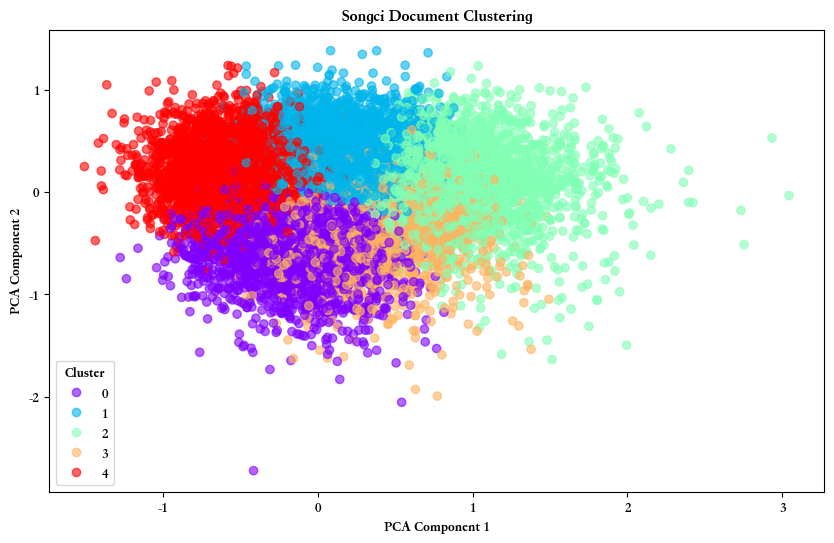

In [ ]:
ci_doc_vectors = np.array([ci_doc_model.dv[i] for i in range(len(df_ci))]) # Get the document vectors
kmeans = KMeans(n_clusters=5, random_state=0).fit(ci_doc_vectors) # Initialize the KMeans model
pca = PCA(n_components=2) # Initialize the PCA model
ci_doc_vectors_2d = pca.fit_transform(ci_doc_vectors) # Perform PCA on the document vectors
df_ci['cluster'] = kmeans.labels_#Add the cluster labels to the DataFrame

plt.figure(figsize=(10, 6))
scatter = plt.scatter(ci_doc_vectors_2d[:, 0], ci_doc_vectors_2d[:, 1], c=df_ci['cluster'], cmap='rainbow', alpha=0.6) # Plot the document vectors

plt.title('Songci Document Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.show()


Here, we take the PCA result of the Doc2Vec model of the Chinese poems dataset as an example. K-means have given us the cluster labels of the documents, and with the help of PCA, we can visualize the documents in a 2D space, with each point representing a document and the color representing the cluster label. From the plot, we can see the clustering is basically acceptable, with most of the clusters being well separated from each other. If we dig deeper into the documents in each cluster, we may find more patterns and structures in the poems. Scholars and researchers have concluded some typical styles and themes of the Song Ci poems, and this maybe a good way to verify their conclusions. Yet due to the limitation of my own knowledge and power, this remains to be done in the future.

---

$\large\mathcal{(II)} \text{ Supervised Learning}$ 


***Note: This part is newly added and mainly focuses on the supervised learning problem.***

## Mapping the Winds: Weak Supervised Learning for Thematic Analysis

### Introduction

In the linguistics and cultural studies of Songci (poems in Song Dynasty), thematic analysis is a fundamental and pivotal task. There have been many studies by linguists and cultural researchers to analyze the themes of Songci. Typically, people would consider the major themes of Songci as the following:
- Nature Imagery and Lyricism
- Farewell and Dedication Poetry
- Feminine Lament and Domestic Melancholy
- Historical Allusion and Nostalgia
- Exilic Longing and Nostalgic Reflection
- Philosophical Meditations on Life

On the other hands, statiticians have been working on NLP techniques to analyze the structural patterns of poems, trying to find the hidden themes of the poems in an analytical way, and can traditionally be regarded as a supervised classification problem. However, one of the major challenges in this task is the lack of labeled data. 

With the development of Large Language Models (LLMs), such classification job could be more easily done by those advanced models. Yet it does not mean that those traditional methods are no longer useful. For one thing, the LLMs are usually more costly to train and deploy. For another, the traditional methods focus more on the structural patterns of the text, which could be more interpretable and explainable, and of more practical meaning in the field of linguistics and cultural studies.

Therefore, in this assignment, we are going to explore a weak supervised learning method for thematic analysis of Songci. Here, weak supervision means that the labels will be generated by LLMs and are not always reliable. Then several traditional machine learning models will be trained to classify the poems into different themes. Several techniques will be used to improve the performance of the models.

### Psuedo Labeling

As is mentioned in the introduction, the original data does not have labels, so it becomes a weak supervised learning problem. 

To be specific, here we design a efficient prompt through prompt engineering together with domain knowledge for ChatGPT 3.5 Turbo api to generate labels for the original data independently two times. Only those labels that are consistent in both two times will be kept. Then the labels generated will be randomly sampled and examined manually to ensure the quality of the labels. 

***First import the data and generate psuedo labels***


> Note that several codes with respect to the data import and LLM api interaction have been commented out as it only needs to be run once. The final data for the model training has been saved as a csv file named `final_data.csv`. 


In [ ]:
import math
import random
import re

import jieba
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from gensim.models import Word2Vec
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             make_scorer)
from sklearn.model_selection import (StratifiedKFold, cross_val_predict,
                                     cross_val_score, train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from xgboost import XGBClassifier

In [ ]:
# Load the data
# data = pd.read_csv('data.csv').replace('\n','', regex=True)
# data = data.sample(2000)
# dat1 = data.iloc[:500, 1:3]
# dat2 = data.iloc[500:1000, 1:3]
# dat3 = data.iloc[1000:1500, 1:3]
# dat4 = data.iloc[1500:2000, 1:3]

Here, ChatGPT 3.5 Turbo api is used to generate labels for the original data. The following code is used to generate labels for the original data. 

In [ ]:
# openai.api_key = "" # my personal openai key has been omitted

# def generate_label_prompt(poem):
#     """ As the api is to process Chinese poems, the prompt is in Chinese for better performance. """
#     prompt = f"""请阅读以下诗歌，并判断其主要主题。主题可以选择以下几种之一：写景抒情 咏史怀古 送别题赠 羁旅思乡 人生感怀 思妇闺怨 其他
#     诗歌内容：{poem}
#     请返回一个最适合的主题标签。请你直接回答上述给出的主题之一，不需要提供任何解释或理由。你只允许从上述主题中选择一个，不允许输出其他任何无关内容。"""
#     return prompt

# def get_label_from_gpt(poem):
#     response = openai.ChatCompletion.create(
#         model="gpt-3.5-turbo",
#         messages=[
#             {"role": "system", "content": "你需要对中国的宋词诗歌的主题进行分类。请严格按照格式要求回答。"},
#             {"role": "user", "content": generate_label_prompt(poem)}
#         ],
#         max_tokens=10,  # Limit len of output to enusre proper labels
#         temperature=0.1  # Low temperature to ensure stable output
#     )
#     label = response['choices'][0]['message']['content'].strip()
#     return label


The LLM has been run 2 times sperately to obtain a more reliable result. 

In [ ]:
# # Pseudo Labeling (I)
# dat1['label1'] = dat1['content'].apply(get_label_from_gpt)
# dat2['label1'] = dat2['content'].apply(get_label_from_gpt)
# dat3['label1'] = dat3['content'].apply(get_label_from_gpt)
# dat4['label1'] = dat4['content'].apply(get_label_from_gpt)

In [ ]:
# # Pseudo Labeling (II)
# dat1['label2'] = dat1['content'].apply(get_label_from_gpt)
# dat2['label2'] = dat2['content'].apply(get_label_from_gpt)
# dat3['label2'] = dat3['content'].apply(get_label_from_gpt)
# dat4['label2'] = dat4['content'].apply(get_label_from_gpt)

Merge the pseudo labels and filter out the problematic labels. 


In [ ]:
# # Merge dat1, dat2, dat3, and dat4
# merged_data = pd.concat([dat1, dat2, dat3, dat4], ignore_index=True) 
# print(merged_data.label1.value_counts()) # Display the counts of each label


# # Drop rows with problematic labels
# labels_to_keep = ['写景抒情', '咏史怀古', '送别题赠', '羁旅思乡', '人生感怀', '思妇闺怨']
# filtered_data = merged_data[merged_data['label1'].isin(labels_to_keep)] # Only keep the determined labels
# final_data = filtered_data[filtered_data['label1'] == filtered_data['label2']] # Only keep rows where two labels are the same
# final_data = final_data.drop(columns=['label2']) # Only need 1 label as they are same
# final_data = final_data.rename(columns={'label1': 'label'}) # Rename the column
# final_data.to_csv('final_data.csv', index=False) # Save the data
# final_data.head()

label1
写景抒情    757
送别题赠    492
思妇闺怨    265
咏史怀古    196
羁旅思乡    166
人生感怀    118
其他        4
思乡闺怨      1
宴会题赠      1
Name: count, dtype: int64


,content,label
0,瑞日初迟，绪风乍暖，千花百草争香。瑶池路稳，阆苑春深，云树水殿相望。柳曲沙平，看尘随青盖，絮...,写景抒情
1,荆溪清晓。问昨夜南枝，几分春到。一点幽芳，不待陇头音耗。亭亭水边月下，胜人间、等闲花草。此际...,写景抒情
2,雪压小桥溪路断。独立无言，雾鬓风鬟乱。拂拭冰霜君试看。一枝堪寄天涯远。拟向南邻寻酒伴。折得花...,送别题赠
4,天末残霞卷暮红。波间时见没凫翁。斜风细雨家何在，老矣生涯尽个中。惟此意，与公同。未须持酒祝牛...,人生感怀
5,春又老。愁似落花难扫。一醉一回才忘了。醒来还满抱。此恨欲凭谁道。柳外数声啼鸟。只恐春风吹不到...,思妇闺怨


The labeled data is saved as `final_data.csv` for the model training.

In [3]:
# Import data for recurrent use
final_data = pd.read_csv('final_data.csv')

Translate the labels into English for better understanding.

In [4]:
# Translate the labels into English
label_translation = {
    '写景抒情': 'Nature Imagery and Lyricism', 
    '咏史怀古': 'Historical Allusion and Nostalgia',  
    '送别题赠': 'Farewell and Dedication Poetry',  
    '羁旅思乡': 'Exilic Longing and Nostalgic Reflection', 
    '人生感怀': 'Philosophical Meditations on Life', 
    '思妇闺怨': 'Feminine Lament and Domestic Melancholy'  
}
final_data['label_eng'] = final_data['label'].map(label_translation)
final_data.label_eng.value_counts()

label_eng
Nature Imagery and Lyricism                733
Farewell and Dedication Poetry             467
Feminine Lament and Domestic Melancholy    252
Historical Allusion and Nostalgia          191
Exilic Longing and Nostalgic Reflection    153
Philosophical Meditations on Life          107
Name: count, dtype: int64

By looking through the distributions of the labels, we have found that the labels are not balanced. Here we choose to temporally ignore least frequent label 'Philosophical Meditations on Life' to make the data more balanced, with finally 1796 samples in total.

In [6]:
final_data = final_data[final_data['label_eng'] != 'Philosophical Meditations on Life']
final_data.reset_index(drop=True, inplace=True)
final_data

,content,label,label_eng
0,瑞日初迟，绪风乍暖，千花百草争香。瑶池路稳，阆苑春深，云树水殿相望。柳曲沙平，看尘随青盖，絮...,写景抒情,Nature Imagery and Lyricism
1,荆溪清晓。问昨夜南枝，几分春到。一点幽芳，不待陇头音耗。亭亭水边月下，胜人间、等闲花草。此际...,写景抒情,Nature Imagery and Lyricism
2,雪压小桥溪路断。独立无言，雾鬓风鬟乱。拂拭冰霜君试看。一枝堪寄天涯远。拟向南邻寻酒伴。折得花...,送别题赠,Farewell and Dedication Poetry
3,春又老。愁似落花难扫。一醉一回才忘了。醒来还满抱。此恨欲凭谁道。柳外数声啼鸟。只恐春风吹不到...,思妇闺怨,Feminine Lament and Domestic Melancholy
4,白雪梨花红粉桃。露华高。垂杨慢舞绿丝绦。草如袍。风过小池轻浪起，似江皋。千金莫惜买香醪。且陶陶。,写景抒情,Nature Imagery and Lyricism
...,...,...,...
1791,芍药开残春已尽。红浅香乾，蝶子迷花阵。阵是清和人正困。行云散後空留恨。小字金书频与问。意曲心...,思妇闺怨,Feminine Lament and Domestic Melancholy
1792,晴浦溶溶明断霞。楼台摇影处，是谁家。银红裙裥皱宫纱。风前坐，闲斗郁金芽。人散树啼鸦。粉团黏不...,写景抒情,Nature Imagery and Lyricism
1793,人物风流册府仙。谁教落魄到穷边。独班未引甘泉伏，三峡先寻上水船。斟楚酒，扣湘弦。竹枝歌里意凄...,送别题赠,Farewell and Dedication Poetry
1794,净客之名从此有。多谢风流，飞驭陪尊酒。持此一卮同劝後。愿花长在人长寿。,送别题赠,Farewell and Dedication Poetry


### Classification under Weak Supervision

In this section, the classification model that we are going to train includes: support vector machine (SVM), naive Bayes (NB), random forest (RF), XGBoost, and fully connected neural network (FCNN). After data cleaning, there are 1796 observations in the dataset. Cross-validation will be used for model comparison. Due to the limit of the computational resources, the hyperparameters of the models will not be grid searched, but manual tuning has been done to improve the performance as much as possible. The input of all models will be the word2vec embeddings of Songci if without special instructions. Also note that, the using of word2vec will share the information of the words, thus we need to isolate the training and testing data to avoid data leakage, which is done by the `Pipeline` structure in `sklearn`.

#### Vanilla Models

Firstly we will try out the classic vanilla models without any special techniques to see its baseline performance. Since most of these models have been sufficiently introduced in the lectures, these algorithms will be directly implemented without detailed explanations.

***Definition of Word2Vec Class***

Since we are going to apply `Pipeline` in `sklearn`, we need to self-define a class for word2vec transformation. Moreover, for Chinese context's tokenization, it is better to use `jieba` for word segmentation. Part of the implementations refer to the following references $^\dagger$.

>$^\dagger$ Refs: https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html, https://blog.csdn.net/Delusional/article/details/114477987

In [8]:
# Define Word2VecVectorizer class
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=300, window=5, min_count=5, sg=1, epochs=10):
        self.vector_size = vector_size # Dim of word vectors
        self.window = window # Context window size
        self.min_count = min_count # Min freq to include a word
        self.sg = sg  # 1 for skip-gram; otherwise CBOW
        self.epochs = epochs # Num of training epochs
        self.word2vec_model = None # Init Word2Vec model
    
    def fit(self, X, y=None):
        tokenized_sentences = [jieba.lcut(doc) for doc in X] # Tokenize sentences using jieba (for Chinese text)
        # Train Word2Vec model
        self.word2vec_model = Word2Vec(
            sentences=tokenized_sentences, 
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            sg=self.sg,
            epochs=self.epochs,
            workers=4,
            seed=111
        )
        return self
    
    def transform(self, X):
        # Tokenize sentences
        tokenized_sentences = [jieba.lcut(doc) for doc in X] # Tokenize using jieba
        sentence_vectors = [] #Init list to store sentence vectors
        for tokens in tokenized_sentences:
            word_vectors = [self.word2vec_model.wv[token] for token in tokens if token in self.word2vec_model.wv] # wv is the word vector
            if word_vectors: # If there are word vectors
                sentence_vectors.append(np.mean(word_vectors, axis=0)) # Average word vectors to get sentence vector
            else: # If no word vectors
                sentence_vectors.append(np.zeros(self.vector_size)) # Append zeros
        return np.array(sentence_vectors) # Return sentence vectors

***Definition of the Algorithms***

First numericalize the labels and define CV function

In [9]:
# Label encoding
label_classes = final_data['label_eng'].unique() # Get unique labels
label_to_idx = {label: idx for idx, label in enumerate(label_classes)} # Assign a unique index to each label
idx_to_label = {idx: label for label, idx in label_to_idx.items()} # Reverse mapping
y_noisy_numeric = final_data['label_eng'].map(label_to_idx).values # Map labels to indices

# K-Fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=111)

# Define accuracy scorer
accuracy_scorer = make_scorer(accuracy_score)

Define Random Forest, Naive Bayes, SVM, XGBoost, and Fully Connected Neural Network piplines. For each pipeline, word2vec will first give the input embeddings, and then the corresponding model will be trained.

In [44]:
pipeline_rf = Pipeline([
    ('w2v', Word2VecVectorizer()),
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=111))
])
pipeline_svm = Pipeline([
    ('w2v', Word2VecVectorizer()),
    ('clf', SVC(kernel='linear', class_weight='balanced', probability=True, random_state=111))
])
pipeline_gnb = Pipeline([
    ('w2v', Word2VecVectorizer()),
    ('clf', GaussianNB())
])
pipeline_xgb = Pipeline([
    ('w2v', Word2VecVectorizer()),
    ('clf', XGBClassifier(eval_metric='mlogloss', random_state=111))
])
pipeline_fcnn = Pipeline([
    ('w2v', Word2VecVectorizer(vector_size=300, window=5, min_count=5, sg=1, epochs=10)),
    ('clf', MLPClassifier(hidden_layer_sizes=(128,), activation='relu', solver='adam', max_iter=500, random_state=111))
]) # Here we use the MLPClassifier as a feedforward neural network rather than calling keras is to better integrate with sklearn's pipeline

Cross-validation for each model

*Naive Bayes*

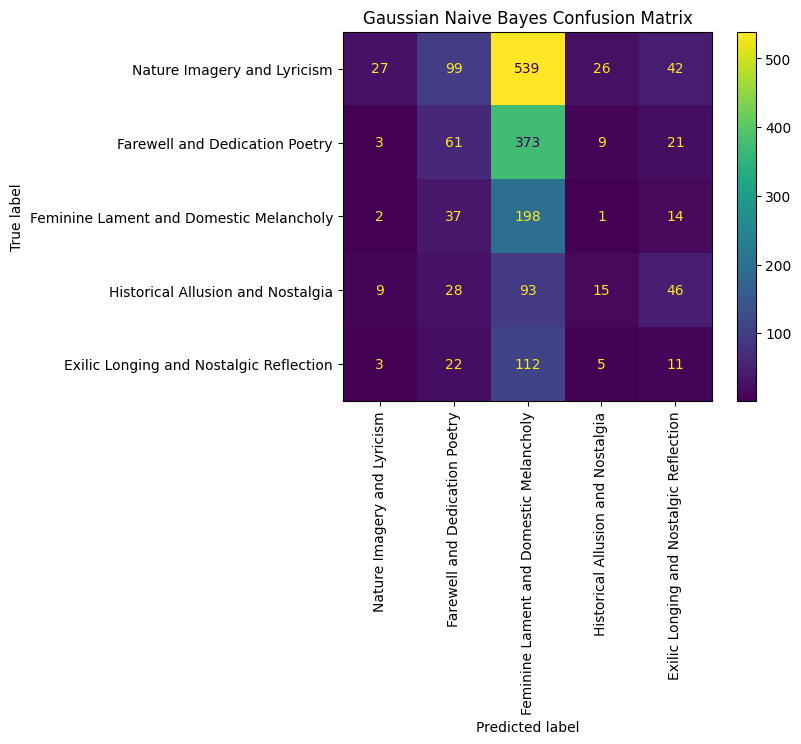

Gaussian Naive Bayes Cross-Validation Accuracy: 0.16871711544413492
Accuracy Scores: [0.15277778 0.21169916 0.16155989 0.13649025 0.1810585 ]


In [37]:
scores_gnb = cross_val_score(pipeline_gnb, final_data['content'], y_noisy_numeric, cv=skf, scoring=accuracy_scorer) # Cross-validation
y_pred_gnb = cross_val_predict(pipeline_gnb, final_data['content'], y_noisy_numeric, cv=skf) # Cross-validation predictions
cm_gnb = confusion_matrix(y_noisy_numeric, y_pred_gnb) # Confusion matrix
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gnb, display_labels=label_classes)
disp.plot(xticks_rotation='vertical')
plt.title("Gaussian Naive Bayes Confusion Matrix")
plt.show()

print("Gaussian Naive Bayes Cross-Validation Accuracy:", scores_gnb.mean())
print("Accuracy Scores:", scores_gnb)

*Support Vector Machine*

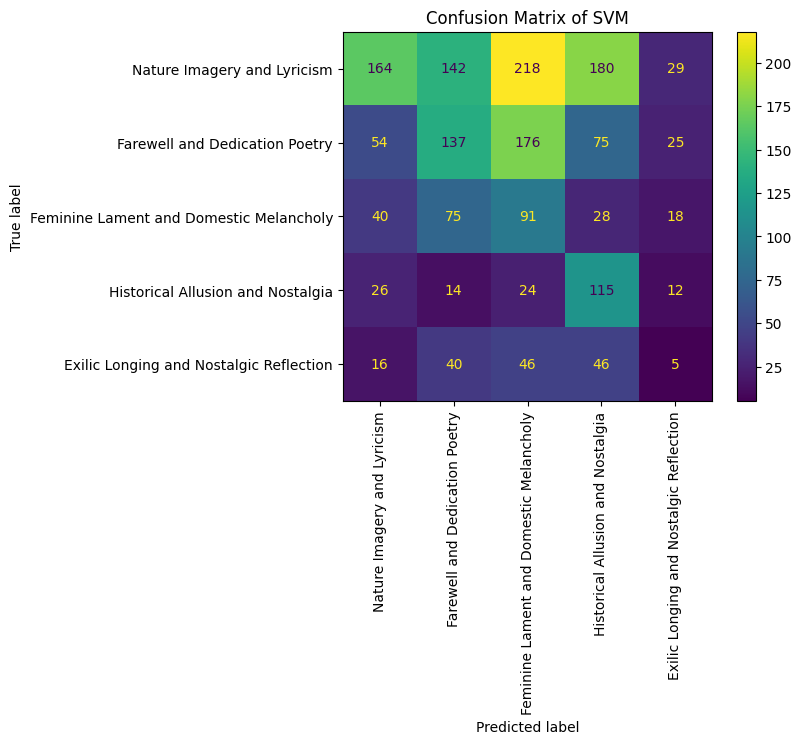

SVM Cross-Validation Accuracy: 0.31127824203033116
Accuracy Scores of SVM: [0.25555556 0.21448468 0.33426184 0.3816156  0.37047354]


In [35]:
scores_svm = cross_val_score(pipeline_svm, final_data['content'], y_noisy_numeric, cv=skf, scoring=accuracy_scorer) # Cross-validation
y_pred_svm = cross_val_predict(pipeline_svm, final_data['content'], y_noisy_numeric, cv=skf) # Cross-validation predictions
cm_svm = confusion_matrix(y_noisy_numeric, y_pred_svm) # Confusion matrix
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=label_classes)
disp.plot(xticks_rotation='vertical')
plt.title('Confusion Matrix of SVM')
plt.show()

print("SVM Cross-Validation Accuracy:", scores_svm.mean())
print("Accuracy Scores of SVM:", scores_svm)

*Random Forest*

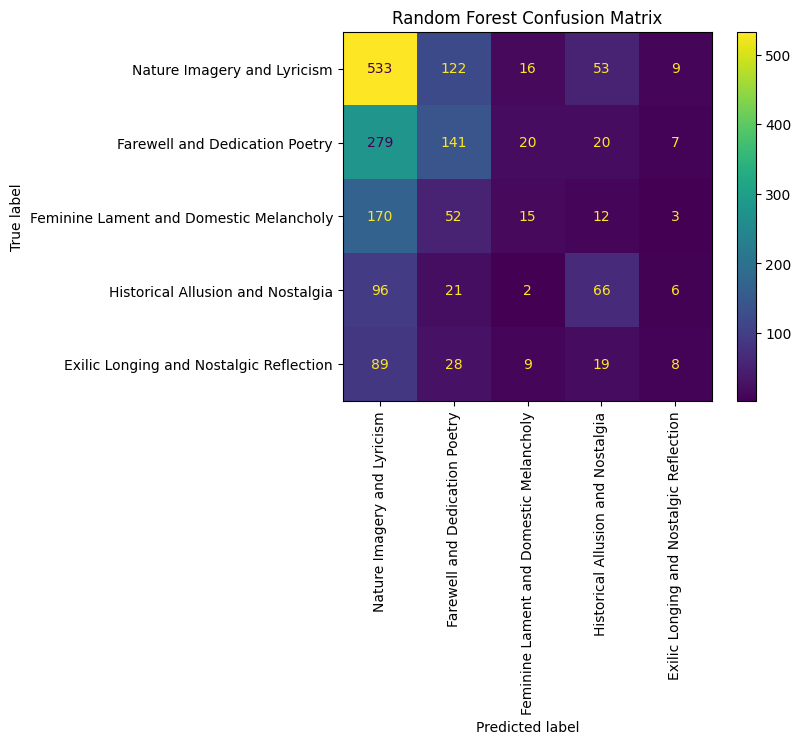

Random Forest Cross-Validation Accuracy: 0.41593314763231204
Accuracy Scores of RF: [0.4        0.40389972 0.43454039 0.40947075 0.43175487]


In [56]:
scores_rf = cross_val_score(pipeline_rf, final_data['content'], y_noisy_numeric, cv=skf, scoring=accuracy_scorer) # Cross-validation
y_pred_rf = cross_val_predict(pipeline_rf, final_data['content'], y_noisy_numeric, cv=skf) # Cross-validation predictions
cm_rf = confusion_matrix(y_noisy_numeric, y_pred_rf) # Confusion matrix
# Plot confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=label_classes)
disp_rf.plot(xticks_rotation='vertical')
plt.title("Random Forest Confusion Matrix")
plt.show()

print("Random Forest Cross-Validation Accuracy:", scores_rf.mean())
print("Accuracy Scores of RF:", scores_rf)

*XGBoost*

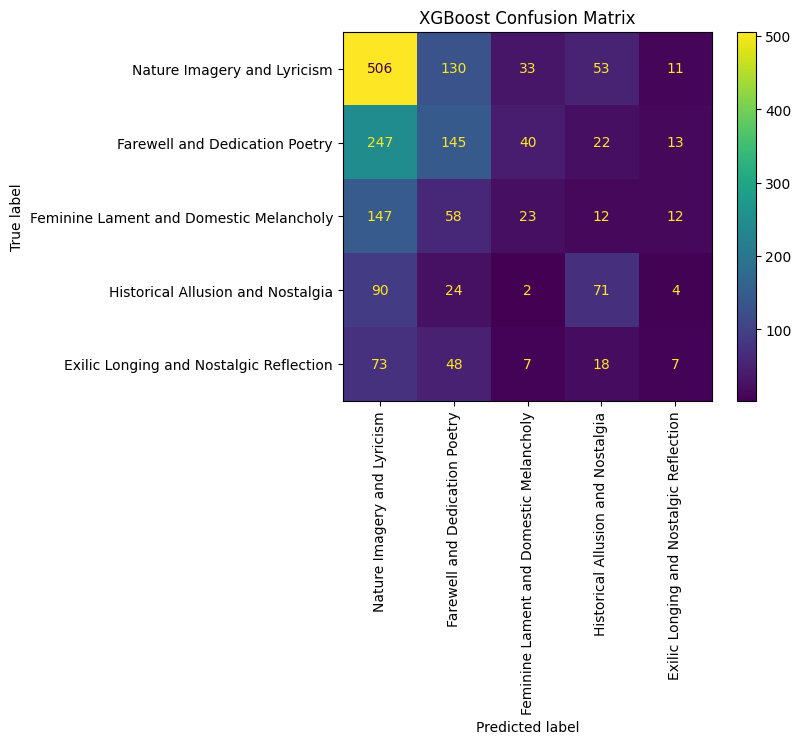

XGBoost Cross-Validation Accuracy: 0.42149179820489013
Accuracy Scores of XGB : [0.42222222 0.454039   0.40111421 0.40111421 0.42896936]


In [ ]:
scores_xgb = cross_val_score(pipeline_xgb, final_data['content'], y_noisy_numeric, cv=skf, scoring=accuracy_scorer) # Cross-validation
y_pred_xgb = cross_val_predict(pipeline_xgb, final_data['content'], y_noisy_numeric, cv=skf) # Cross-validation predictions
cm_xgb = confusion_matrix(y_noisy_numeric, y_pred_xgb) # Confusion matrix
# Plot confusion matrix
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=label_classes)
disp_xgb.plot(xticks_rotation='vertical')
plt.title('XGBoost Confusion Matrix')
plt.show()

print("XGBoost Cross-Validation Accuracy:", scores_xgb.mean())
print("Accuracy Scores of XGB :", scores_xgb)

*Fully Connected Neural Network*

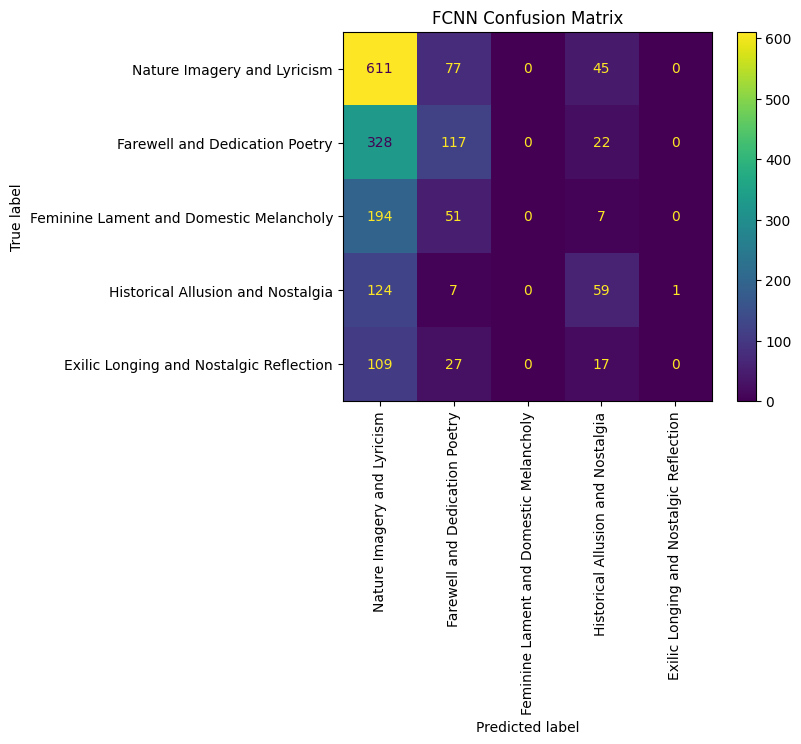

FCNN Cross-Validation Accuracy: 0.43429588362735994
Accuracy Scores of FCNN: [0.43888889 0.43454039 0.454039   0.40947075 0.43454039]


In [34]:
scores_fcnn = cross_val_score(pipeline_fcnn, final_data['content'], y_noisy_numeric, cv=skf, scoring=accuracy_scorer) # Compute cross-validation scores
y_pred_fcnn = cross_val_predict(pipeline_fcnn, final_data['content'], y_noisy_numeric, cv=skf) # Predict labels using cross-validation
cm_fcnn = confusion_matrix(y_noisy_numeric, y_pred_fcnn) # Compute confusion matrix
# Plot confusion matrix
disp_fcnn = ConfusionMatrixDisplay(confusion_matrix=cm_fcnn, display_labels=label_classes)
disp_fcnn.plot(xticks_rotation='vertical')
plt.title('FCNN Confusion Matrix')
plt.show()

print("FCNN Cross-Validation Accuracy:", scores_fcnn.mean())
print("Accuracy Scores of FCNN:", scores_fcnn)


From the results, we can see that generally XGBoost and Fully Connected Neural Network have the best performance, whose average accuracy are both around $42.9\%$. Random forest is also close to them, while the performance of SVM and Naive Bayes are not as good as the other three models. 

Generally we can tell that the largest class '*Nature Imagery and Lyricism*' still has a very strong influence on the classification results. The imbalance of the data will bias the classification results towards the majority class.

#### Co-training for Weak Supervision

Co-training is a semi-supervised learning technique that can be used to improve the performance of the models under weak supervision. The basic idea of co-training is to train two models on different views of the data, and then use the predictions of one model to label the data for the other model. In this way, the models can learn from each other and improve their performance.

In this project, we will use XGBoost as the co-training algorithm, consider its good performance and computational efficiency. This part of code has referred to the following reference $^\dagger$.

>$^\dagger$ Ref: https://blog.csdn.net/q7w8e9r4/article/details/132575400

In [ ]:
# Co-Training Framework
class CoTrainingClassifier:
    def __init__(self, classifier1, classifier2, max_iterations=10, selection_size=10, threshold=0.8):
        self.classifier1 = classifier1
        self.classifier2 = classifier2
        self.max_iterations = max_iterations
        self.selection_size = selection_size
        self.threshold = threshold
    
    def fit(self, X, y):
        # Split data into labeled and unlabeled
        np.random.seed(111)
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        unlabeled_size = int(0.2 * X.shape[0]) # 20% of data is unlabeled
        labeled_indices = indices[unlabeled_size:] 
        unlabeled_indices = indices[:unlabeled_size]
        
        X_labeled = X[labeled_indices]
        y_labeled = y[labeled_indices]
        
        X_unlabeled = X[unlabeled_indices]
        
        for iteration in range(self.max_iterations):
            
            # Train classifiers
            self.classifier1.fit(X_labeled, y_labeled)
            self.classifier2.fit(X_labeled, y_labeled)
            
            # Predict probabilities on unlabeled data
            probs1 = self.classifier1.predict_proba(X_unlabeled) # predict_proba returns the probability of each class
            probs2 = self.classifier2.predict_proba(X_unlabeled)
            
            # Select confident predictions from classifier1
            confidence1 = np.max(probs1, axis=1)
            confident_indices1 = np.where(confidence1 >= self.threshold)[0]
            selected_indices1 = confident_indices1[:self.selection_size]
            selected_labels1 = self.classifier1.predict(X_unlabeled[selected_indices1])
            
            # Select confident predictions from classifier2
            confidence2 = np.max(probs2, axis=1)
            confident_indices2 = np.where(confidence2 >= self.threshold)[0]
            selected_indices2 = confident_indices2[:self.selection_size]
            selected_labels2 = self.classifier2.predict(X_unlabeled[selected_indices2])
            
            # Add new labeled data
            if len(selected_indices1) == 0 and len(selected_indices2) == 0:
                print("No more confident predictions. Stopping co-training.")
                break
            
            if len(selected_indices1) > 0: 
                X_new1 = X_unlabeled[selected_indices1]
                y_new1 = selected_labels1
                X_labeled = np.vstack((X_labeled, X_new1))
                y_labeled = np.concatenate((y_labeled, y_new1))
            
            if len(selected_indices2) > 0:
                X_new2 = X_unlabeled[selected_indices2]
                y_new2 = selected_labels2
                X_labeled = np.vstack((X_labeled, X_new2))
                y_labeled = np.concatenate((y_labeled, y_new2))
            
            # Remove newly labeled data from unlabeled set
            remove_indices = np.concatenate((selected_indices1, selected_indices2))
            X_unlabeled = np.delete(X_unlabeled, remove_indices, axis=0)
            
        
        # Final training
        self.classifier1.fit(X_labeled, y_labeled)
        self.classifier2.fit(X_labeled, y_labeled)
        return self
    
    def predict(self, X):
        # Average the predictions of both classifiers
        probs1 = self.classifier1.predict_proba(X)
        probs2 = self.classifier2.predict_proba(X)
        avg_probs = (probs1 + probs2) / 2
        return np.argmax(avg_probs, axis=1)

# Initialization
classifier1 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=111)
classifier2 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=112)  
cotraining = CoTrainingClassifier(
    classifier1=classifier1,
    classifier2=classifier2,
    max_iterations=10,
    selection_size=10,
    threshold=0.85
)

In [74]:
def cotraining_cross_val_score(cotraining, X, y, cv, scorer): # Combine Co-Training with Cross-Validation
    scores = []
    for fold, (train_index, test_index) in enumerate(cv.split(X, y), 1):
        # Split data into training and testing
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        
        # Initialize Co-Training model
        fold_cotraining = CoTrainingClassifier(
            classifier1=XGBClassifier( eval_metric='mlogloss', random_state=111),
            classifier2=XGBClassifier( eval_metric='mlogloss', random_state=112),
            max_iterations=10,
            selection_size=10,
            threshold=0.8
        )
        # Fit Co-Training model
        fold_cotraining.fit(X_train, y_train)
        # Predict on test data
        y_pred = fold_cotraining.predict(X_test)
        # Calculate accuracy
        score = scorer(y_test, y_pred)
        scores.append(score)
        print(f"Fold {fold} Accuracy: {score:.4f}")
    return np.array(scores)

vectorizer = Word2VecVectorizer()
X_vectors = vectorizer.fit_transform(final_data['content'])

scores = cotraining_cross_val_score(cotraining, X_vectors, y_noisy_numeric, skf, accuracy_scorer)

print("\nCo-Training with XGBoost Cross-Validation Accuracy:", scores.mean())
print("Accuracy Scores per Fold:", scores)

Fold 1 Accuracy: 0.4056
Fold 2 Accuracy: 0.4429
Fold 3 Accuracy: 0.4875
Fold 4 Accuracy: 0.4345
Fold 5 Accuracy: 0.4680

Co-Training with XGBoost Cross-Validation Accuracy: 0.4476849272671
Accuracy Scores per Fold: [0.40555556 0.44289694 0.48746518 0.43454039 0.46796657]


From the output of the CV, the performance has been improved by co-training from $42.149\%$ to $44.768\%$. It shows that co-training can be an effective way to improve the performance of the models under weak supervision.

### Conclusion

In this assignment, we have explored a weak supervised learning method for thematic analysis of Songci. ChatGPT 3.5 Turbo api has been used to generate pseudo labels, and then several traditional machine learning models have been trained to classify the poems into different given themes. Co-training has been used to improve the performance of the models, and the best accuracy performance is around $44.768\%$.

Yet there are still several limitations in this project. Firstly, the data is not balanced, which will bias the classification results towards the majority class. Secondly, the labels generated by ChatGPT 3.5 may not be reliable. The lack of expert knowledge in the generation of pseudo labels may also affect the performance of the models. Thirdly, the hyperparameters of the models have not been grid searched, which may affect the performance of the models. Fourthly, the co-training algorithm is still very simple, and the two views of the data may not be diverse enough. Deeper exploration of the co-training algorithm is needed in future work. Finally, though the performance of the models has a significant difference from the random guess ($20\%$), there is still a large room for improvement.

However, it does show the existence of some certain linguistic patterns in the poems, which can be captured by the traditional machine learning models, and analytically explained.

## Where does the East () find the earth : Language Sequence Completion via Transformers


### Introduction

As the last part of the assignment, we are going to explore the language sequence completion task via transformers, which is can be regarded as the most fundamental task by the most classic modeel in the field of NLP. To be specific, the model will be given a sequence of words (here a sentence of a poem), and the model needs to predict the next word in the sequence.

Modern large language models (LLMs) have achieved remarkable performance on this task. While we are not expecting to achieve the same level, we are still interested in reproducing the process and to see how far we can go with the limited computational resources.

### Data Preprocessing

First import the songci data and clean the data to filter out non-Chinese characters. Note that, as we are here predicting the next character of the sequence, we should split the data into characters instead of tokenizing with jieba.

In [92]:
# Load the data
df = pd.read_csv('data.csv').replace('\n', '', regex=True)
contents = df['content'].tolist() # Get the contents of the songci

# Remove non-Chinese characters
def clean_data(contents):
    cleaned_contents = []
    for line in contents:
        cleaned_line = re.sub(r'[^\u4e00-\u9fff]', '', line)
        cleaned_contents.append(cleaned_line)
    return cleaned_contents

cleaned_contents = clean_data(contents)

Then create the input-output pairs for the model training. The input will be a sequence of characters of some arbitrary length except for the last character, and that last character will be the output.

In [104]:
# Create target char for each input sequence
def input_target_pairs(contents):
    input_sequences = []
    target_chars = []
    for line in contents:
        chars = list(line)
        if len(chars) < 2:
            continue  # Skip lines that are too short
        input_seq = chars[:-1]
        target = chars[-1]
        input_sequences.append(input_seq)
        target_chars.append(target)
    return input_sequences, target_chars

input_sequences, target_chars = input_target_pairs(cleaned_contents)

Next, we have to numericalize the characters and create a dictionary for the characters. Each character will be represented by a unique integer.

In [107]:
# Build a vocabulary set for all characters
all_chars = set()
for seq in input_sequences:
    all_chars.update(seq)
all_chars.update(target_chars)

# Map char to index 
char2idx = {char: idx+2 for idx, char in enumerate(sorted(all_chars))} 
# Add special tokens <PAD> and <UNK>
char2idx['<PAD>'] = 0  # Padding token
char2idx['<UNK>'] = 1  # Unknown token

# Map index to char
idx2char = {idx: char for char, idx in char2idx.items()}
vocab_size = len(char2idx)

Then we can translate a sequence of chars to a sequence of integers.

In [109]:
# Translate char seq to index seq
def encode_sequences(sequences, char2idx):
    encoded_sequences = []
    for seq in sequences:
        # Convert each character in the sequence to its corresponding index
        encoded_seq = [char2idx.get(char, char2idx['<UNK>']) for char in seq]
        encoded_sequences.append(torch.tensor(encoded_seq, dtype=torch.long))
    return encoded_sequences

# Translate char target to index target
def encode_targets(targets, char2idx):
    encoded_targets = [char2idx.get(char, char2idx['<UNK>']) for char in targets]
    return torch.tensor(encoded_targets, dtype=torch.long)

# Encoded inputs and targets are the final data for training
encoded_inputs = encode_sequences(input_sequences, char2idx)
encoded_targets = encode_targets(target_chars, char2idx)

Maintain a data loader for the model training.

In [110]:
class PoemDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs  # List of input sequences (tensors)
        self.targets = targets  # List of target indices

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]
    
    def collate_fn(batch):
        inputs, targets = zip(*batch)
        # Pad the input sequences to have the same length
        inputs = pad_sequence(inputs, batch_first=True, padding_value=char2idx['<PAD>'])
        targets = torch.tensor(targets, dtype=torch.long)
        # Generate the padding mask
        src_key_padding_mask = (inputs == char2idx['<PAD>'])
        return inputs, targets, src_key_padding_mask
    
# Initialize the dataset
dataset = PoemDataset(encoded_inputs, encoded_targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=PoemDataset.collate_fn)
        

### Model Implementation

First define the Positional Encoding of the transformer. Part of the implementation refers to the following reference $^\dagger$.

>$^\dagger$ Ref: https://towardsdatascience.com/language-models-for-sentence-completion-6a5298a85e43, https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html


In [118]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        if embed_size % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].to(x.device)
        return x

In [121]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_size=256, num_heads=8, num_layers=2):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)  
        self.pos_encoder = PositionalEncoding(embed_size)  
        encoder_layers = TransformerEncoderLayer(d_model=embed_size, nhead=num_heads)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_size, vocab_size) 

    def forward(self, src, src_key_padding_mask=None):
        embedded = self.embedding(src) 
        embedded = self.pos_encoder(embedded)  
        embedded = embedded.transpose(0, 1)  
        transformer_output = self.transformer_encoder(embedded, src_key_padding_mask=src_key_padding_mask)
        seq_lengths = (~src_key_padding_mask).sum(dim=1) - 1  
        outputs = transformer_output[seq_lengths, torch.arange(transformer_output.size(1)), :]  
        logits = self.fc_out(outputs)
        return logits  


Initialize the model and start training. Due to the limit of the computational resources, the model will be trained for 40 epochs.

Epoch 1 Loss: 7.3914
Epoch 2 Loss: 6.6638
Epoch 3 Loss: 5.8803
Epoch 4 Loss: 4.2112
Epoch 5 Loss: 2.4996
Epoch 6 Loss: 1.1415
Epoch 7 Loss: 0.4256
Epoch 8 Loss: 0.1367
Epoch 9 Loss: 0.0444
Epoch 10 Loss: 0.0178
Epoch 11 Loss: 0.0138
Epoch 12 Loss: 0.0084
Epoch 13 Loss: 0.0065
Epoch 14 Loss: 0.0066
Epoch 15 Loss: 0.0051
Epoch 16 Loss: 0.0058
Epoch 17 Loss: 0.0100
Epoch 18 Loss: 0.0061
Epoch 19 Loss: 0.0202
Epoch 20 Loss: 0.4947
Epoch 21 Loss: 2.5019
Epoch 22 Loss: 1.0531
Epoch 23 Loss: 0.2887
Epoch 24 Loss: 0.0832
Epoch 25 Loss: 0.0269
Epoch 26 Loss: 0.0143
Epoch 27 Loss: 0.0089
Epoch 28 Loss: 0.0096
Epoch 29 Loss: 0.0077
Epoch 30 Loss: 0.0075


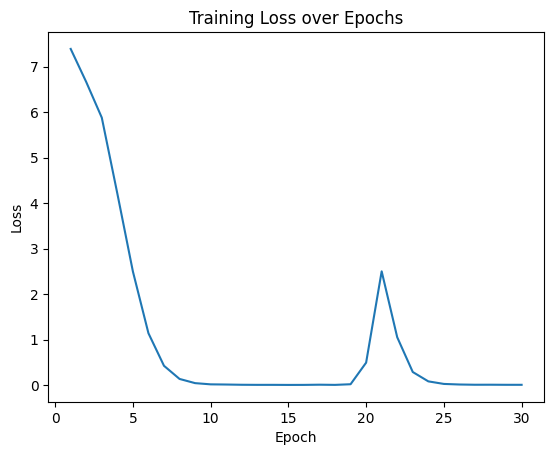

In [133]:
# Set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the model
model = TransformerModel(vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Import matplotlib for plotting
import matplotlib.pyplot as plt

loss_values = []  # List to store loss values

# Start training
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets, src_key_padding_mask in dataloader:
        # Transfer data to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        src_key_padding_mask = src_key_padding_mask.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(inputs, src_key_padding_mask)
        # Compute the loss
        loss = criterion(output, targets)
        # Backpropagation
        loss.backward()
        # Update the parameters and loss
        optimizer.step()
        total_loss += loss.item()
    # Compute the average loss
    avg_loss = total_loss / len(dataloader)
    loss_values.append(avg_loss)  # Record loss for plotting
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

# Plot the training loss over epochs
plt.plot(range(1, num_epochs + 1), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

Finally, we can define a function to generate the next character of the sequence. The function will input a sequence of characters and output the next character predicted by the model. Here, we will output the top 8 possible characters and their probabilities.

In [187]:
def predict_next_char(model, input_seq, char2idx, idx2char, device, top_k=8):
    model.eval()
    chars = list(input_seq)
    encoded_seq = [char2idx.get(char, char2idx['<UNK>']) for char in chars]
    input_tensor = torch.tensor(encoded_seq, dtype=torch.long).unsqueeze(0).to(device)
    src_key_padding_mask = (input_tensor == char2idx['<PAD>']).to(device)
    with torch.no_grad():
        output = model(input_tensor, src_key_padding_mask)
        probs = nn.functional.softmax(output.squeeze(0), dim=-1)
        top_prob, top_idx = torch.topk(probs, top_k)
        top_chars = [idx2char[idx.item()] for idx in top_idx]
        return list(zip(top_chars, top_prob.cpu().numpy()))

Let's test this model with the most famous Songci poem by Su Shi, "千里共婵（？）"(Moonlight shines a thousand miles) to see if the model can predict the last character of the poem.

In [188]:
#-----------------------DIY-----------------------#
# You may substitute the input with your interested Chinese poem
input = "千里共婵"
#-------------------------------------------------#

predictions = predict_next_char(model, input, char2idx, idx2char, device)
print("Top 8 Predictions:")
for char, prob in predictions:
    print(f"Character: {char}, Probability: {prob:.4f}")

Top 8 Predictions:
Character: 娟, Probability: 0.5965
Character: 翠, Probability: 0.2655
Character: 路, Probability: 0.0160
Character: 琼, Probability: 0.0117
Character: 首, Probability: 0.0088
Character: 疆, Probability: 0.0086
Character: 去, Probability: 0.0048
Character: 圆, Probability: 0.0040


Seems it has made it!

And if we take one step further, we can repeatedly call the function to generate a sequence of characters. Then, as long as the length of the desired sequence is given with a starting character, the model will generate the sequence of characters.

In [202]:
import random
def generate_poetry_top2_random(model, initial_char, length, char2idx, idx2char, device):
    model.eval() 
    generated_sequence = [initial_char]  

    for _ in range(length - 1):
        input_seq = ''.join(generated_sequence)  
        preds = predict_next_char(model, input_seq, char2idx, idx2char, device, top_k=3) 
        top_chars, top_probs = zip(*preds)  
        next_char = random.choices(top_chars, weights=top_probs, k=1)[0]
        generated_sequence.append(next_char) 

    generated_line = ''.join(generated_sequence)  
    return generated_line

#-----------------------DIY-----------------------#
# You may substitute the initial_char and length with your Chinese characters and desired length 
initial_char = '天'  
length = 7 
#-------------------------------------------------#

generated_line = generate_poetry_top2_random(
    model, initial_char, length, char2idx, idx2char, device
)
print(f"Poem generated: {generated_line}")

Poem generated: 天游是春梢玉沙


Finally, as a final piece of the puzzle, let's try the inspiring sentence "Where does the East Wind find the earth?" This is a more challenging task as the model has never seen this sentence before. (As this sentence is concluded by the top frequently used words in the Songci dataset, but not a real sentence in the dataset.)

In [203]:
input = "人间何处是东"
predictions = predict_next_char(model, input, char2idx, idx2char, device)
print("Top 8 Predictions:")
for char, prob in predictions:
    print(f"Character: {char}, Probability: {prob:.4f}")

Top 8 Predictions:
Character: 风, Probability: 0.3881
Character: 篱, Probability: 0.1936
Character: 味, Probability: 0.1493
Character: 流, Probability: 0.1357
Character: 窗, Probability: 0.0291
Character: 南, Probability: 0.0144
Character: 皇, Probability: 0.0134
Character: 雪, Probability: 0.0055


Here we have successfully got the character "风" (wind), which is exactly we have been expecting. Sweet!

### Conclusion

In this section, we have tried to reproduce the language sequence completion task via transformers. The model has been trained on the Songci data, and it has successfully predicted some of the target characters, and at least most of the predictions are reasonable linguistically. It of course has a long way to go to achieve the same level of the state-of-the-art models, but it does show the potential of the transformer model in the language sequence completion task.